# Projet 4 : Anticipez les besoins en consommation de bâtiments<br>- Phase de nettoyage et exploration
## Sommaire
* [Importation des bibliothèques](#import_bib)
* [Lecture des données](#lec_donn)
* [Filtrage des propriétés résidentielles](#filt_res)
* [Affichage des détails statistiques de base des données numériques](#affich_stats)
* [Suppression des caractéristiques invariantes](#supp_invar)
* [Correction de la casse des lettres incohérentes](#corr_casse)
* [Comparaison des adresses aux coordonnées géographiques](#comp_addr)
* [Suppression des propriétés avec données par défaut](#supp_don_def)
* [Suppression des propriétés sans données sur l'énergie ou les émissions](#supp_sans_ener)
* [Calcul de la consommation d'énergie à la source](#calc_src)
    * [Reconstitution de la consommation d'énergie des bâtiments et de la surface foncière](#recon_ener)
    * [Détermination du mode de calcul de l'intensité par propriété](#deter_calc_inten)
    * [Calcul de la consommation d'énergie à la source à partir de l'intensité](#inser_src_ener)
* [Suppression des propriétés aberrantes indiquées](#supp_abber)
* [Remplissage des codes postaux manquants à l'aide d'un géocodeur](#remp_code_post)
* [Suppression des propriétés sans données sur l'énergie normalisée ou le type d'utilisation principale](#supp_sans_typ_prop)
* [Remplacement des valeurs manquantes appropriées par 0 et des chaînes vides](#val_manq_zero)
* [Visualisation de la distribution des caractéristiques catégorielles](#vis_dist_cat)
* [Visualisation de la distribution des caractéristiques continues](#vis_dist_cont)
* [Visualisation de la corrélation entre les caractéristiques continues](#vis_corr_cont)
* [Création de nouvelles caractéristiques d'intensité plus cohérentes](#creat_inten)
* [Visualisation de la distribution des intensités de consommation d'énergie](#vis_dist_intens)
* [Visualisation de la répartition des intensités énergétiques par type de bien](#vis_repar_intens_typ_prop)
* [Évaluation de la relation entre la consommation d'énergie et les émissions et la cote ENERGY STAR](#relat_es_ener_emis)
    * [Visualisation de la corrélation entre ENERGY STAR et les intensités de consommation d'énergie par type de propriété](#vis_corr_es_inten)
    * [Graphiques de régression ENERGY STAR et intensité des émissions par type de propriété](#regres_es_emis)
    * [MANOVA entre ENERGY STAR et les intensités de consommation d'énergie](#manova)
    * [ACP du score ENERGY STAR et les valeurs d'intensité](#acp)
* [Suppression de caractéristiques non pertinentes](#supp_carac_non_pert)
* [Correction des types de données des caractéristiques](#corr_type_donn)
* [Enregistrement du dataframe nettoyé](#enreg_df)

    
## Importation des bibliothèques <a class="anchor" id="import_bib"></a>

In [32]:
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA


## Lecture des données <a class="anchor" id="lec_donn"></a>

In [33]:
build_ener_df = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

## Filtrage des propriétés résidentielles <a class="anchor" id="filt_res"></a>

In [34]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[
    (
        ~build_ener_df["BuildingType"].isin(
            ["Multifamily HR (10+)", "Multifamily LR (1-4)", "Multifamily MR (5-9)"]
        )
    )
    & (
        ~build_ener_df["PrimaryPropertyType"].isin(
            [
                "High-Rise Multifamily",
                "Low-Rise Multifamily",
                "Mid-Rise Multifamily",
                "Residence Hall",
            ]
        )
    )
    & (
        ~build_ener_df["LargestPropertyUseType"].isin(
            [
                "Multifamily Housing",
                "Other - Lodging/Residential",
                "Residence Hall/Dormitory",
            ]
        )
    )
]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


3376
1629


## Affichage des détails statistiques de base des données numériques <a class="anchor" id="affich_stats"></a>

In [35]:
with pd.option_context("display.max_columns", None):
    display(build_ener_df.describe())


,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1629.000000,1629.0,1613.000000,1629.000000,1629.000000,1629.000000,1629.000000,1627.000000,1629.000000,1.629000e+03,1629.000000,1.629000e+03,1.623000e+03,835.000000,340.000000,1071.000000,1626.000000,1626.000000,1627.000000,1627.000000,1.627000e+03,1.626000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,1.627000e+03,0.0,1627.000000,1627.000000
mean,16106.317986,2016.0,98116.699318,4.353591,47.615659,-122.333159,1961.905463,1.171481,4.108042,1.195486e+05,13048.470227,1.065002e+05,9.965446e+04,36943.391972,14737.801173,65.459384,72.503567,74.898463,176.912354,179.114321,8.546335e+06,8.159922e+06,5.217879e+05,1.735611e+06,5.921906e+06,1.988956e+04,1.988956e+06,NaN,187.193159,1.610621
std,13777.032930,0.0,17.999159,2.202625,0.048462,0.024682,32.525830,2.964442,6.572922,2.997562e+05,42658.828996,2.866328e+05,2.797603e+05,69982.245841,36814.369790,28.535926,74.745771,75.731759,187.696999,187.686657,3.058713e+07,2.227995e+07,5.578664e+06,6.163686e+06,2.103050e+07,9.478920e+04,9.478920e+06,NaN,760.638229,2.358555
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,577.000000,2016.0,98105.000000,2.000000,47.584540,-122.343400,1930.000000,1.000000,1.000000,2.961900e+04,0.000000,2.853100e+04,2.572200e+04,5222.500000,2587.750000,48.000000,33.700001,35.450001,76.500000,79.250000,1.222025e+06,1.287964e+06,0.000000e+00,2.118562e+05,7.228535e+05,0.000000e+00,0.000000e+00,NaN,19.840000,0.340000
50%,21117.000000,2016.0,98109.000000,4.000000,47.612200,-122.333050,1965.000000,1.000000,2.000000,4.976000e+04,0.000000,4.767300e+04,4.416200e+04,12000.000000,5744.000000,73.000000,51.750000,53.750000,131.300003,134.500000,2.559462e+06,2.691883e+06,0.000000e+00,4.744772e+05,1.618916e+06,4.910900e+03,4.910900e+05,NaN,49.290000,0.870000
75%,24560.000000,2016.0,98125.000000,7.000000,47.649040,-122.321930,1989.000000,1.000000,4.000000,1.060000e+05,0.000000,9.471300e+04,9.206750e+04,31954.500000,12535.250000,89.000000,81.649998,85.499998,204.100006,205.849998,6.979178e+06,7.239068e+06,0.000000e+00,1.436401e+06,4.901002e+06,1.517566e+04,1.517566e+06,NaN,144.600000,1.875000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.258640,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


## Suppression des caractéristiques invariantes <a class="anchor" id="supp_invar"></a>

In [36]:
dropped_cols = []

for col in build_ener_df.columns:
    if (
        len(set(build_ener_df[col].to_list())) == 1
        or len(build_ener_df[col].loc[~build_ener_df[col].isna()].to_list()) == 0
    ):
        dropped_cols += [col]
        build_ener_df = build_ener_df.drop(labels=col, axis=1)

display(dropped_cols)


['DataYear', 'City', 'State', 'Comments']

## Correction de la casse des lettres incohérentes <a class="anchor" id="corr_casse"></a>

In [37]:
print(sorted(set(build_ener_df["Neighborhood"].to_list())))

build_ener_df["Neighborhood"] = build_ener_df["Neighborhood"].apply(lambda x: x.upper())

print(sorted(set(build_ener_df["Neighborhood"].to_list())))


['BALLARD', 'Ballard', 'CENTRAL', 'Central', 'DELRIDGE', 'DELRIDGE NEIGHBORHOODS', 'DOWNTOWN', 'Delridge', 'EAST', 'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH', 'NORTHEAST', 'NORTHWEST', 'North', 'Northwest', 'SOUTHEAST', 'SOUTHWEST']
['BALLARD', 'CENTRAL', 'DELRIDGE', 'DELRIDGE NEIGHBORHOODS', 'DOWNTOWN', 'EAST', 'GREATER DUWAMISH', 'LAKE UNION', 'MAGNOLIA / QUEEN ANNE', 'NORTH', 'NORTHEAST', 'NORTHWEST', 'SOUTHEAST', 'SOUTHWEST']


## Comparaison des adresses aux coordonnées géographiques <a class="anchor" id="comp_addr"></a>

In [38]:
addresses = build_ener_df["Address"].to_list()
addr_cnts = {}

for addr in addresses:
    if addresses.count(addr) > 1:
        if addr not in addr_cnts:
            addr_cnts[addr] = addresses.count(addr)

for addr in addr_cnts.keys():
    lats_longs = []
    addr_df = build_ener_df.loc[build_ener_df["Address"] == addr]
    lats = addr_df["Latitude"].to_list()
    longs = addr_df["Longitude"].to_list()

    for i in range(len(lats)):
        lats_longs += [[lats[i], longs[i]]]

    lats_longs = list(set(tuple(sorted(sub)) for sub in lats_longs))
    addr_cnts[addr] = lats_longs

display(addr_cnts)

for addr in addr_cnts.keys():
    if len(addr_cnts[addr]) > 1:
        with pd.option_context("display.max_columns", None):
            display(build_ener_df.loc[build_ener_df["Address"] == addr])


{'500 5TH AVE': [(-122.32927, 47.6029), (-122.32842, 47.60378)],
 '2600 SW Barton St': [(-122.36627, 47.52254)],
 '3613 4th Ave S': [(-122.32811, 47.57199)],
 '1100 Olive Way': [(-122.33086, 47.61597)],
 '100 West Harrison': [(-122.3585, 47.62224)],
 '2203 Airport Way S': [(-122.32417, 47.5829)],
 '309 South Cloverdale Street': [(-122.33064, 47.52549)],
 '201 Thomas St.': [(-122.35251, 47.62082)],
 '2400 11th Ave East': [(-122.31644, 47.64132)],
 '14050 1st Ave NE': [(-122.32784, 47.73143)],
 '10510 5th Ave NE': [(-122.32232, 47.70541)],
 '4636 East Marginal Way South': [(-122.33872, 47.56121)],
 '2600 SW Holden St': [(-122.36624, 47.53419)],
 '2309 S Jackson St': [(-122.30189, 47.59881)]}

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
20,27,NonResidential,Other,King County Correctional Facility,500 5TH AVE,98104.0,0942001010,3,DOWNTOWN,47.60378,-122.32842,1985,1.0,19,385274,0,385274,Other,Other,385274.0,NaN,NaN,NaN,NaN,NaN,NaN,124.199997,128.600006,229.500000,232.899994,47859812.0,49539212.0,0.0,5351014.50,18257661.0,296021.5,29602150.0,False,Compliant,NaN,1699.45,4.41
568,779,NonResidential,Large Office,Administration Building,500 5TH AVE,98104.0,0942000920,7,DOWNTOWN,47.60290,-122.32927,1971,1.0,9,224857,0,224857,Office,Office,204993.0,NaN,NaN,NaN,NaN,NaN,79.0,74.500000,78.800003,195.699997,200.899994,15272491.0,16162013.0,4047481.0,3289861.75,11225008.0,0.0,0.0,False,Compliant,NaN,390.67,1.74


## Suppression des propriétés avec données par défaut <a class="anchor" id="supp_don_def"></a>

In [39]:
print(build_ener_df.shape[0])

build_ener_df_def_dat = build_ener_df.loc[build_ener_df["DefaultData"]]
build_ener_df_comp_err = build_ener_df.loc[
    build_ener_df["ComplianceStatus"] == "Error - Correct Default Data"
]

if build_ener_df_def_dat.compare(build_ener_df_comp_err).shape[0] == 0:
    build_ener_df = build_ener_df.loc[
        ~(build_ener_df["ComplianceStatus"] == "Error - Correct Default Data")
    ]

    build_ener_df.reset_index(drop=True, inplace=True)

print(build_ener_df.shape[0])


1629
1541


## Suppression des propriétés sans données sur l'énergie ou les émissions <a class="anchor" id="supp_sans_ener"></a>

In [40]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[
    ~(
        (build_ener_df["SiteEnergyUse(kBtu)"] <= 0)
        | np.isnan(build_ener_df["SiteEnergyUse(kBtu)"])
        | (build_ener_df["TotalGHGEmissions"] <= 0)
        | np.isnan(build_ener_df["TotalGHGEmissions"])
    )
]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


1541
1522


## Calcul de la consommation d'énergie à la source <a class="anchor" id="calc_src"></a>
### Reconstitution de la consommation d'énergie des bâtiments et de la surface foncière <a class="anchor" id="recon_ener"></a>
* Il est indiqué que l'intensité de la consommation d'énergie est la consommation totale d'énergie divisée par la superficie totale de la propriété.
* L'utilisation d'énergie déclarée est comparée à des valeurs reconstituées à partir de l'intensité d'utilisation d'énergie multipliée par la surface du bien et par la surface au sol des bâtiments.
* Cela montre qu'en effet, si l'intensité est parfois calculée en fonction de la surface totale, elle est le plus souvent basée sur les surfaces des bâtiments.

In [41]:
with pd.option_context("display.float_format", "{:.5f}".format):
    display(
        pd.DataFrame(
            {
                "SiteEnergyUse(kBtu)": build_ener_df["SiteEnergyUse(kBtu)"],
                "SiteEnergyUse(kBtu)ReconstTotalProp": build_ener_df["PropertyGFATotal"]
                * build_ener_df["SiteEUI(kBtu/sf)"],
                "SiteEnergyUse(kBtu)ReconstBuildings": build_ener_df[
                    "PropertyGFABuilding(s)"
                ]
                * build_ener_df["SiteEUI(kBtu/sf)"],
            }
        ).head(20)
    )


,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)ReconstTotalProp,SiteEnergyUse(kBtu)ReconstBuildings
0,7226362.50000,7225057.53028,7225057.53028
1,8387933.00000,9818057.11588,8389989.86993
2,72587024.00000,91786560.00000,72901632.00000
3,6794584.00000,6794256.19009,6794256.19009
4,14172606.00000,20156584.54430,13038984.35210
5,12086616.00000,13240897.39346,8178249.36655
6,5758795.00000,5876966.65317,5876966.65317
7,6298131.50000,6299249.22190,6299249.22190
8,13723820.00000,13725460.29985,13725460.29985
9,16016644.00000,18318294.57026,16012526.19917


### Détermination du mode de calcul de l'intensité par propriété <a class="anchor" id="deter_calc_inten"></a>

In [42]:
eui_from_prop_idxs = []
eui_from_bldgs_idxs = []
eui_from_prkng_idxs = []
eui_disparate_idxs = []
ener = "SiteEnergyUse(kBtu)"
eui = "SiteEUI(kBtu/sf)"
gfa_prop = "PropertyGFATotal"
gfa_bldg = "PropertyGFABuilding(s)"
gfa_prk = "PropertyGFAParking"

for index, row in build_ener_df.iterrows():
    abs_diff_ener_prop = abs(row[gfa_prop] * row[eui] - row[ener])
    abs_diff_ener_bldg = abs(row[gfa_bldg] * row[eui] - row[ener])
    abs_diff_ener_prkng = abs(row[gfa_prk] * row[eui] - row[ener])

    if abs_diff_ener_prop < abs_diff_ener_bldg:
        if abs_diff_ener_prkng < abs_diff_ener_prop:
            if abs_diff_ener_prkng / row[ener] >= 0.01:
                eui_disparate_idxs += [index]
                continue
            eui_from_prkng_idxs += [index]
        else:
            if abs_diff_ener_prop / row[ener] >= 0.01:
                eui_disparate_idxs += [index]
                continue
            eui_from_prop_idxs += [index]
    elif abs_diff_ener_prkng < abs_diff_ener_bldg:
        if abs_diff_ener_prkng / row[ener] >= 0.01:
            eui_disparate_idxs += [index]
            continue
        eui_from_prkng_idxs += [index]
    else:
        if abs_diff_ener_bldg / row[ener] >= 0.01:
            eui_disparate_idxs += [index]
            continue
        eui_from_bldgs_idxs += [index]

print(
    f"EUI from proprty GFA: {len(eui_from_prop_idxs)}\n"
    + f"EUI from building GFA: {len(eui_from_bldgs_idxs)}\n"
    + f"EUI from parking GFA: {len(eui_from_prkng_idxs)}\n"
    + f"EUI without corresponding GFA: {len(eui_disparate_idxs)}\n"
)


EUI from proprty GFA: 43
EUI from building GFA: 803
EUI from parking GFA: 0
EUI without corresponding GFA: 676



### Calcul de la consommation d'énergie à la source à partir de l'intensité <a class="anchor" id="inser_src_ener"></a>
* La consommation d'énergie à la source est calculée à partir de l'intensité de la même manière que la consommation d'énergie du site pour chaque propriété.
* L'utilisation de l'énergie à la source est insérée dans la base de données en tant que nouvelle caractéristique.

In [43]:
build_ener_df.insert(
    loc=build_ener_df.columns.get_loc("SiteEnergyUseWN(kBtu)") + 1,
    column="SourceEnergyUseWN(kBtu)",
    value=np.nan,
)

for index, row in build_ener_df.iterrows():
    source_eui = 0

    if (
        not np.isnan(row["SourceEUIWN(kBtu/sf)"])
        and not row["SourceEUIWN(kBtu/sf)"] == 0
    ):
        source_eui = row["SourceEUIWN(kBtu/sf)"]
    else:
        source_eui = row["SourceEUI(kBtu/sf)"]

    if index in eui_from_prop_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prop]
    elif index in eui_from_bldgs_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_bldg]
    elif index in eui_from_prkng_idxs:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prk]
    else:
        build_ener_df.loc[index, "SourceEnergyUseWN(kBtu)"] = source_eui * row[gfa_prop]

with pd.option_context("display.max_columns", None):
    display(build_ener_df.head())


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,1.671403e+07,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,1.587726e+07,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,1.853676e+08,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,1.373568e+07,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,3.785505e+07,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,NaN,505.01,2.88


## Suppression des propriétés aberrantes indiquées <a class="anchor" id="supp_abber"></a>

In [44]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.loc[build_ener_df["Outlier"].isna()]

build_ener_df.reset_index(drop=True, inplace=True)
print(build_ener_df.shape[0])


1522
1508


## Remplissage des codes postaux manquants à l'aide d'un géocodeur <a class="anchor" id="remp_code_post"></a>

In [45]:
no_zip_df = build_ener_df.loc[build_ener_df["ZipCode"].isna()]
geolocator = Nominatim(user_agent="geoapiExercises", timeout=3)

for index, row in no_zip_df.iterrows():
    location = geolocator.geocode(row["Address"] + " Seattle")

    if location is not None:
        build_ener_df.at[index, "ZipCode"] = str.split(
            location.raw["display_name"], ", "
        )[-2]
    else:
        build_ener_df.at[index, "ZipCode"] = str.split(
            geolocator.reverse((row["Latitude"], row["Longitude"])).raw["display_name"],
            ", ",
        )[-2]

print(f"Rows without Zip Code: {build_ener_df['ZipCode'].isna().sum()}")

Rows without Zip Code: 0


## Suppression des propriétés sans données sur l'énergie normalisée ou le type d'utilisation principale <a class="anchor" id="supp_sans_typ_prop"></a>

In [46]:
print(build_ener_df.shape[0])

build_ener_df = build_ener_df.dropna(
    subset=[
        "LargestPropertyUseType",
        "LargestPropertyUseTypeGFA",
        "SiteEnergyUseWN(kBtu)",
    ]
)

print(build_ener_df.shape[0])


1508
1503


## Remplacement des valeurs manquantes appropriées par 0 et des chaînes vides <a class="anchor" id="val_manq_zero"></a>

In [47]:
build_ener_df[
    ["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
] = build_ener_df[
    ["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
].fillna(
    value=0
)
build_ener_df[
    ["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
] = build_ener_df[
    ["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
].fillna(
    value=""
)


## Visualisation de la distribution des caractéristiques catégorielles <a class="anchor" id="vis_dist_cat"></a>

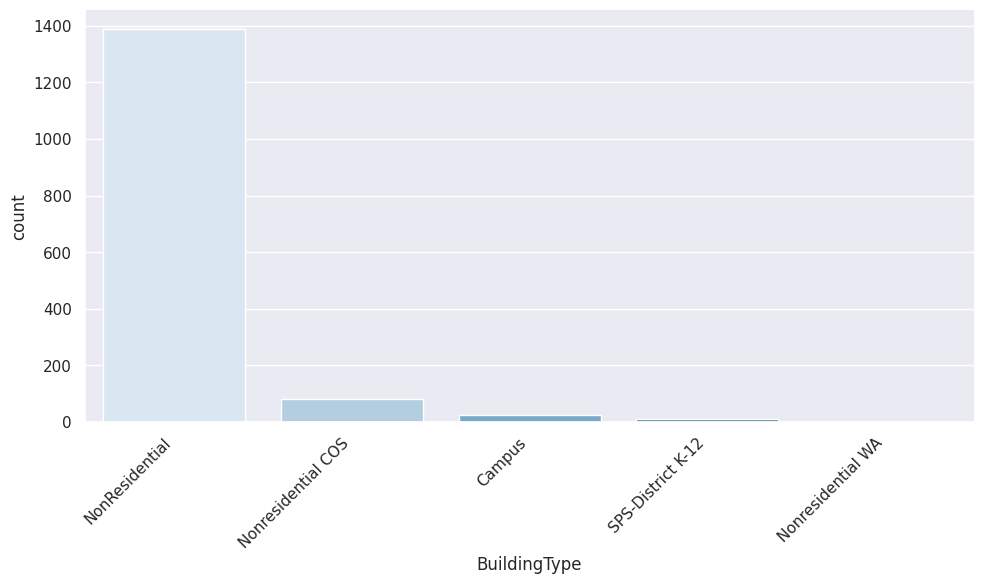

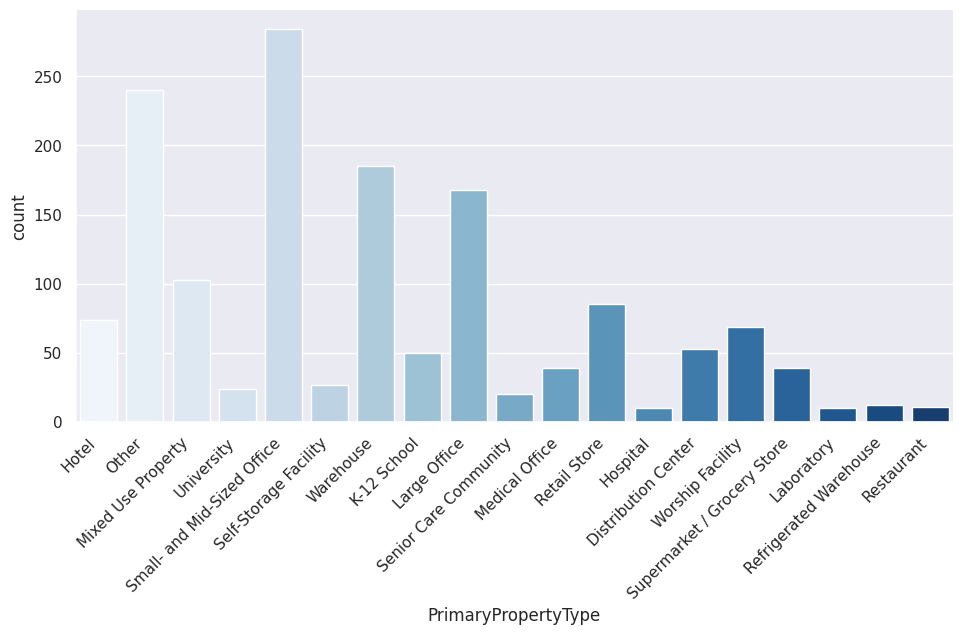

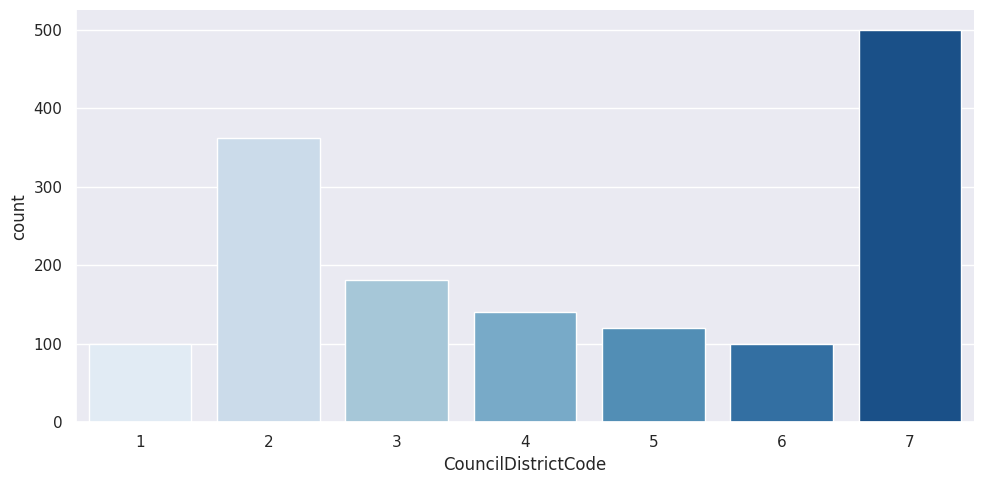

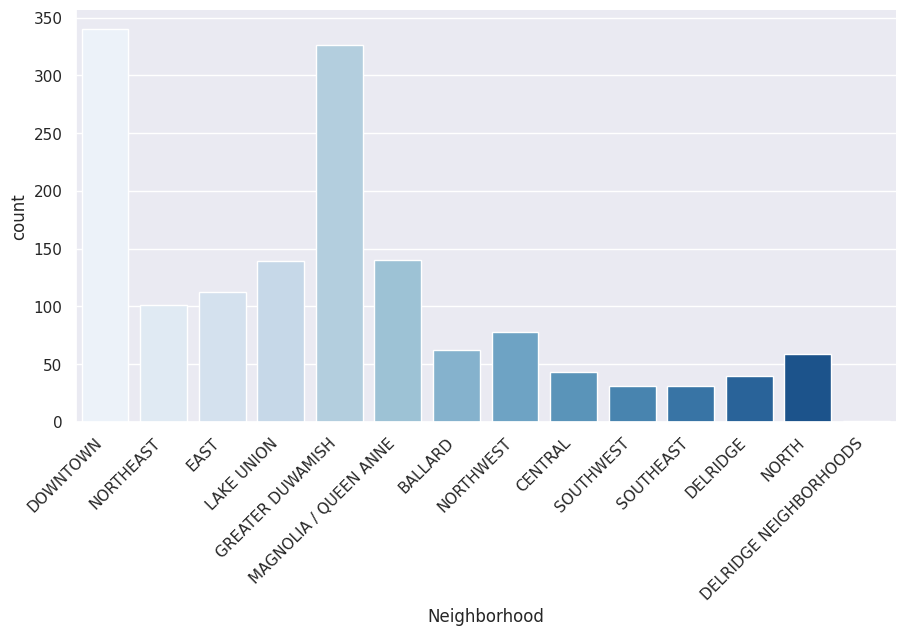

In [48]:
categ_vars = [
    "BuildingType",
    "PrimaryPropertyType",
    "CouncilDistrictCode",
    "Neighborhood",
]

sns.set_theme(style="darkgrid")

for categ in categ_vars:
    cp = sns.catplot(
        data=build_ener_df, x=categ, height=5, aspect=2, kind="count", palette="Blues"
    )
    if categ != "CouncilDistrictCode":
        cp.set_xticklabels(rotation=45, horizontalalignment="right")
    plt.show()


## Visualisation de la distribution des caractéristiques continues <a class="anchor" id="vis_dist_cont"></a>

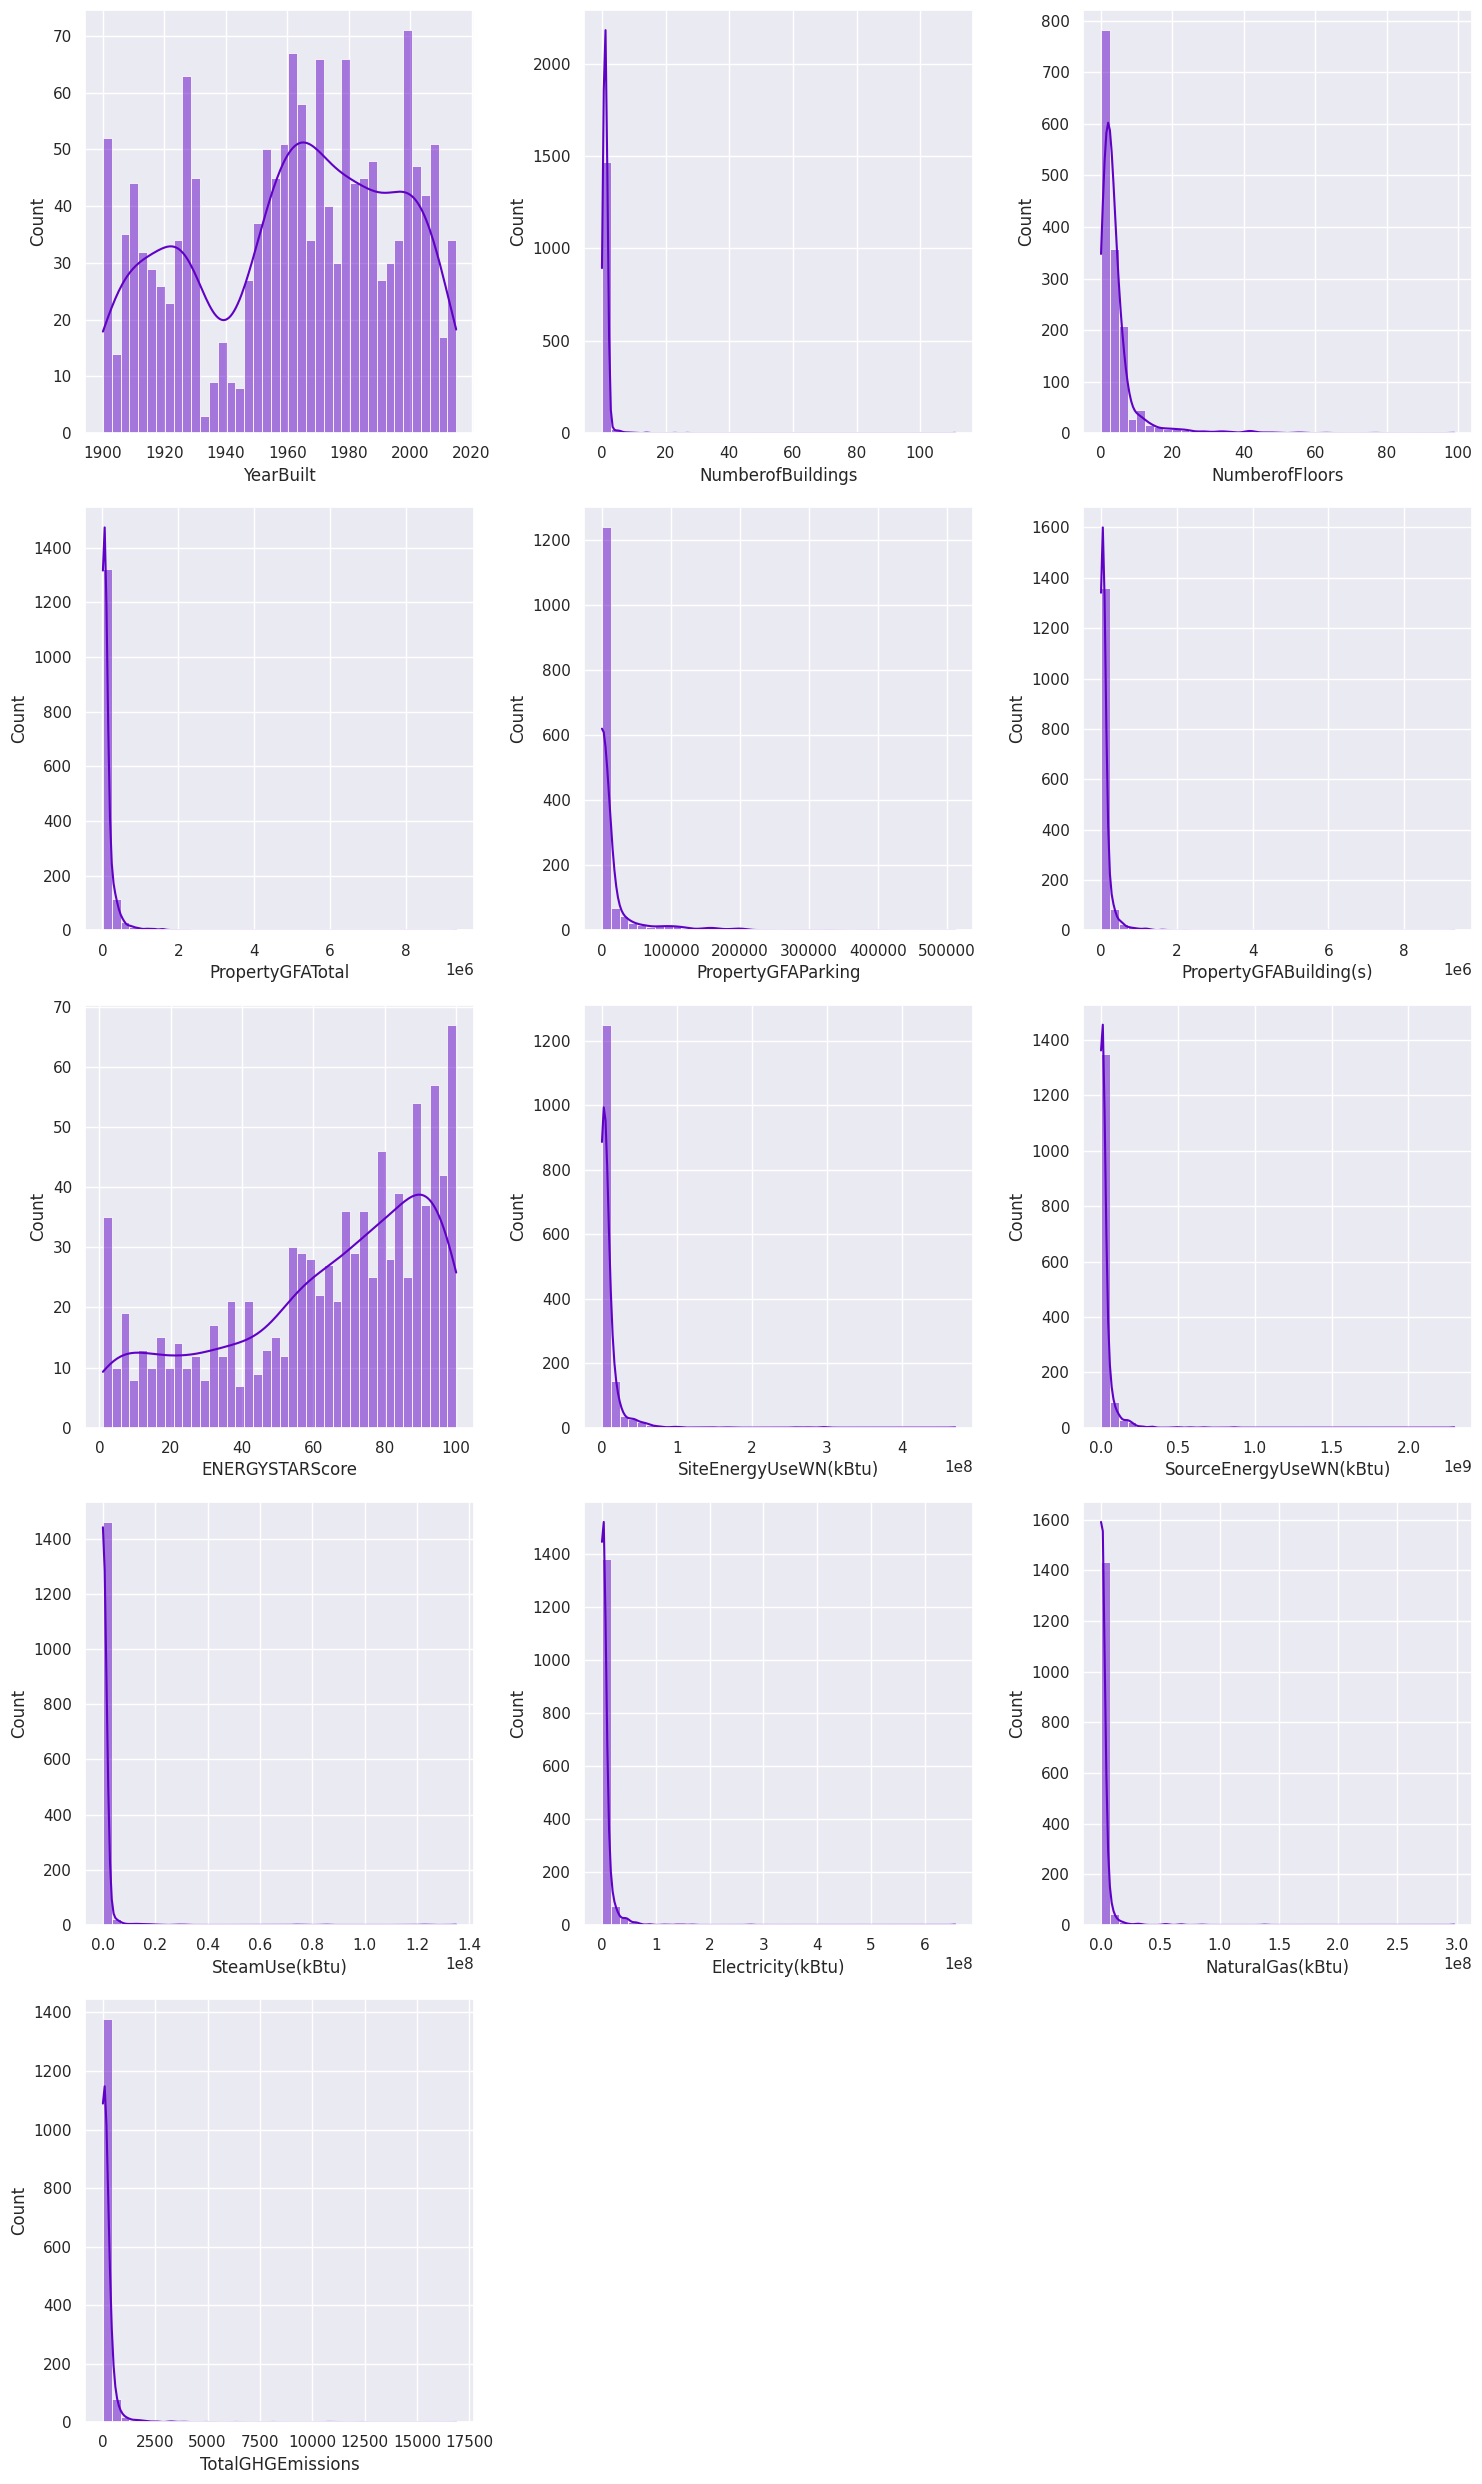

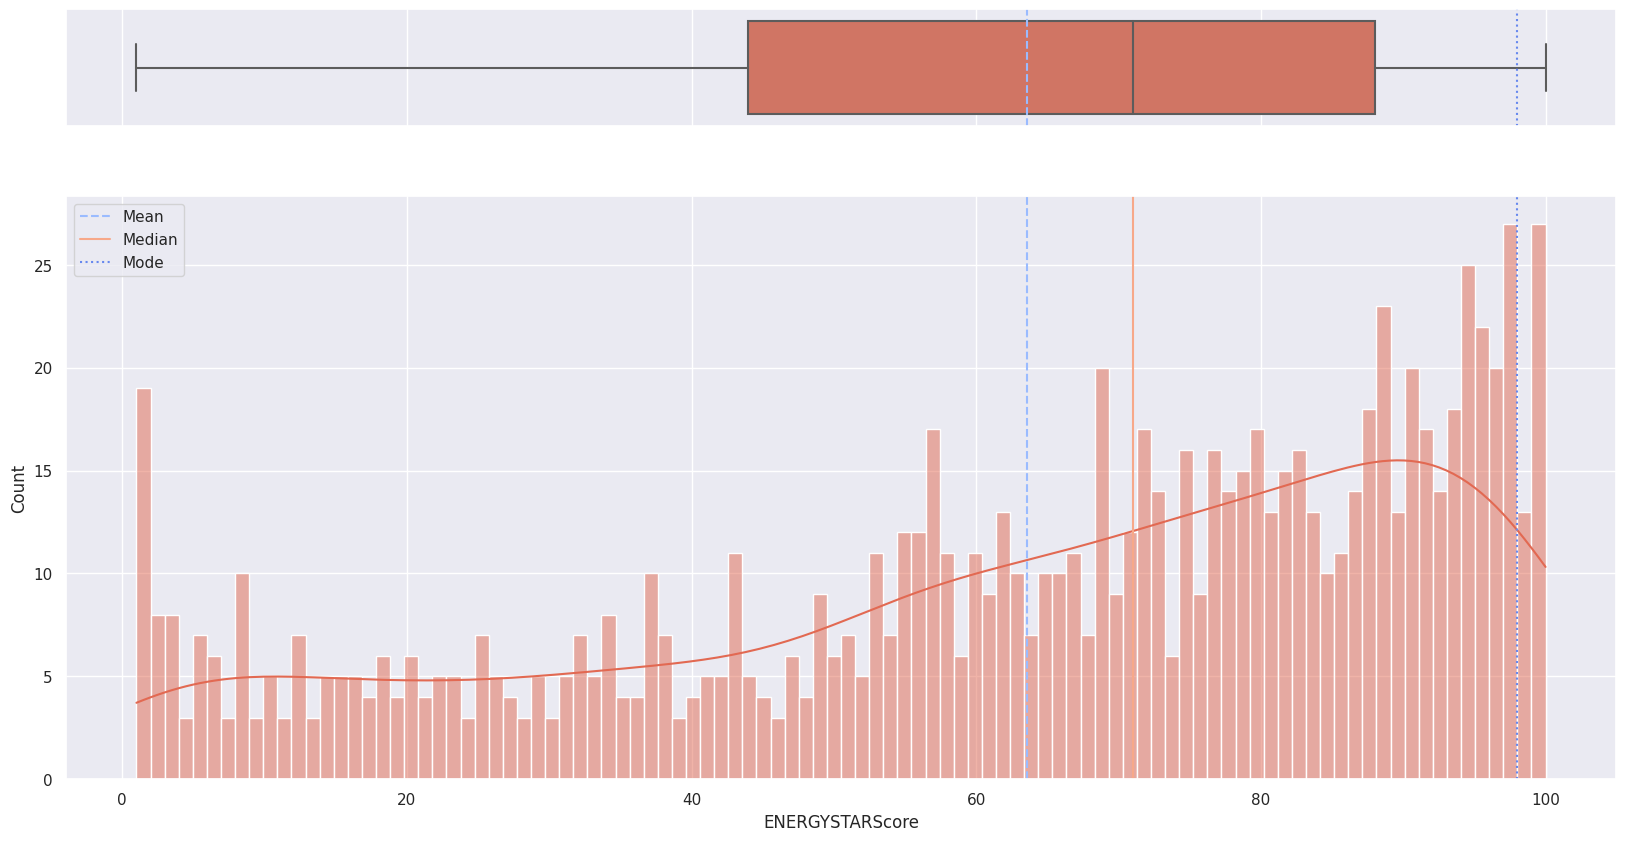

In [53]:
all_continuous = [
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "ENERGYSTARScore",
    "SiteEnergyUseWN(kBtu)",
    "SourceEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)",
    "TotalGHGEmissions",
]
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=3, nrows=5, figsize=(15, 25))
sp_locs = (
    [i for i in ax1]
    + [i for i in ax2]
    + [i for i in ax3]
    + [i for i in ax4]
    + [i for i in ax5]
)
loop_num = 0

sns.set_palette(sns.color_palette("coolwarm"))

for contin in all_continuous:
    sns.histplot(build_ener_df, x=contin, bins=40, ax=sp_locs[loop_num], kde=True)
    loop_num += 1

sp_locs[-1].axis("off")
sp_locs[-2].axis("off")
plt.tight_layout()
plt.show()

build_ener_df_enstr_drop = build_ener_df.copy()
build_ener_df_enstr_drop = build_ener_df_enstr_drop.loc[
    ~build_ener_df_enstr_drop["ENERGYSTARScore"].isna()
].astype({"ENERGYSTARScore": int})
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)}
)
mean = build_ener_df_enstr_drop["ENERGYSTARScore"].mean()
median = build_ener_df_enstr_drop["ENERGYSTARScore"].median()
mode = build_ener_df_enstr_drop["ENERGYSTARScore"].mode().values[0]
theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

sns.set_palette("gnuplot")
sns.set_style("darkgrid")
sns.boxplot(
    data=build_ener_df_enstr_drop, x="ENERGYSTARScore", ax=ax_box, color=theme_clrs[5]
)
ax_box.axvline(mean, color=theme_clrs[1], linestyle="--")
ax_box.axvline(mode, color=theme_clrs[0], linestyle=":")
sns.histplot(
    data=build_ener_df_enstr_drop,
    x="ENERGYSTARScore",
    ax=ax_hist,
    bins=100,
    kde=True,
    color=theme_clrs[5],
)
ax_hist.axvline(mean, color=theme_clrs[1], linestyle="--", label="Mean")
ax_hist.axvline(median, color=theme_clrs[4], linestyle="-", label="Median")
ax_hist.axvline(mode, color=theme_clrs[0], linestyle=":", label="Mode")
ax_hist.legend()
ax_box.set(xlabel="")
plt.show()


## Visualisation de la corrélation entre les caractéristiques continues <a class="anchor" id="vis_corr_cont"></a>

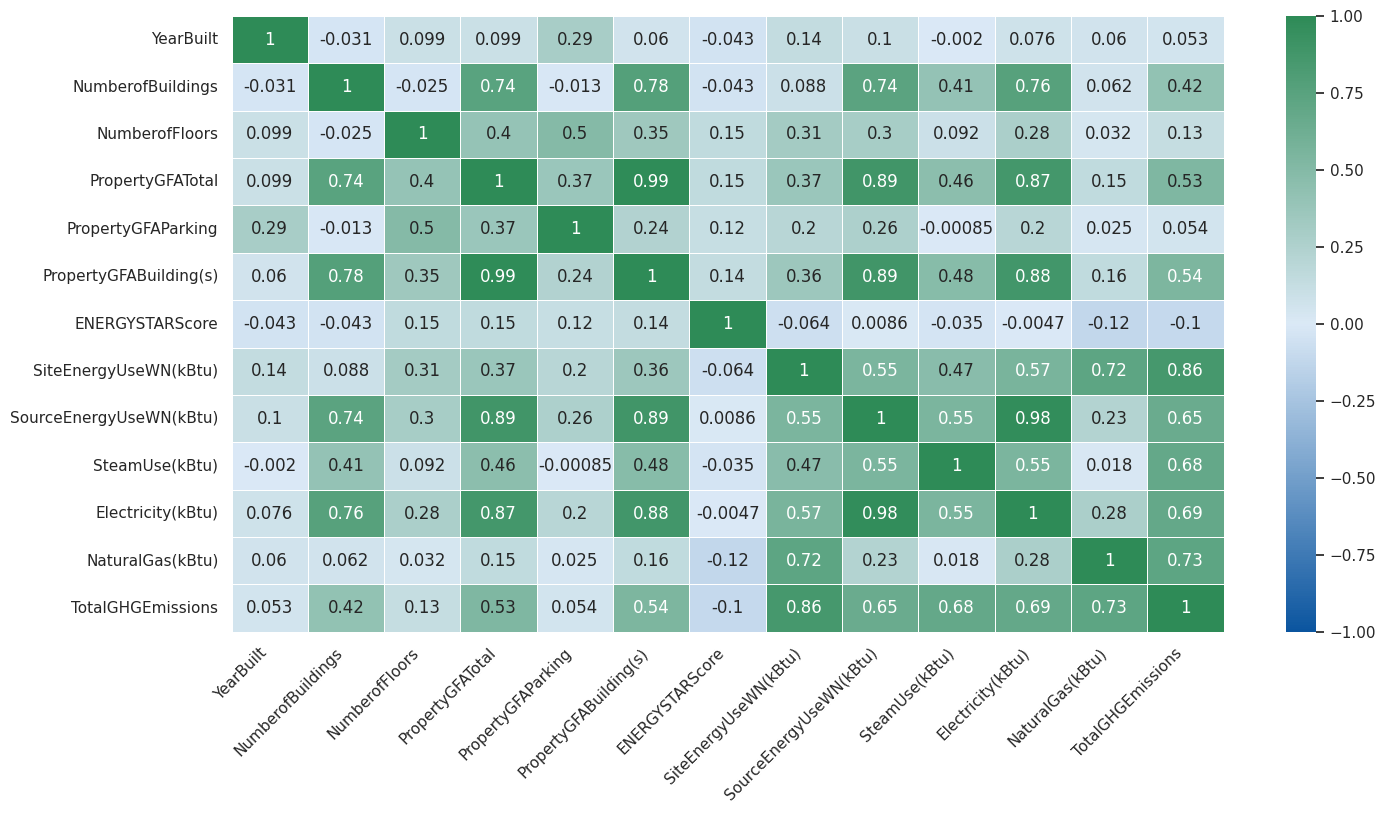

In [54]:
sns.set_palette(sns.color_palette("Blues"))

cont_corr_df = build_ener_df[all_continuous].corr()
f, ax = plt.subplots(figsize=(16, 8))
theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]
cmap = lsc.from_list("DbLbDb", [theme_clrs[5], theme_clrs[0], "seagreen"])

sns.heatmap(
    cont_corr_df,
    vmin=-1.0,
    vmax=1.0,
    cmap=cmap,
    annot=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


## Création de nouvelles caractéristiques d'intensité plus cohérentes <a class="anchor" id="creat_inten"></a>

In [55]:
build_ener_df_w_intens = build_ener_df
ener_cols_intens = [
    ["SiteEnergyUseWN(kBtu)", "SiteEnergyUseIntensityWN(kBtu)"],
    ["SourceEnergyUseWN(kBtu)", "SourceEnergyUseIntensityWN(kBtu)"],
    ["SteamUse(kBtu)", "SteamUseIntensity(kBtu)"],
    ["Electricity(kBtu)", "ElectricityUseIntensity(kBtu)"],
    ["NaturalGas(kBtu)", "NaturalGasUseIntensity(kBtu)"],
]

for cols in ener_cols_intens:
    build_ener_df_w_intens.insert(
        build_ener_df_w_intens.columns.get_loc(cols[0]) + 1,
        cols[1],
        build_ener_df_w_intens[cols[0]] / build_ener_df_w_intens["PropertyGFATotal"],
    )


## Visualisation de la distribution des intensités de consommation d'énergie <a class="anchor" id="vis_dist_intens"></a>

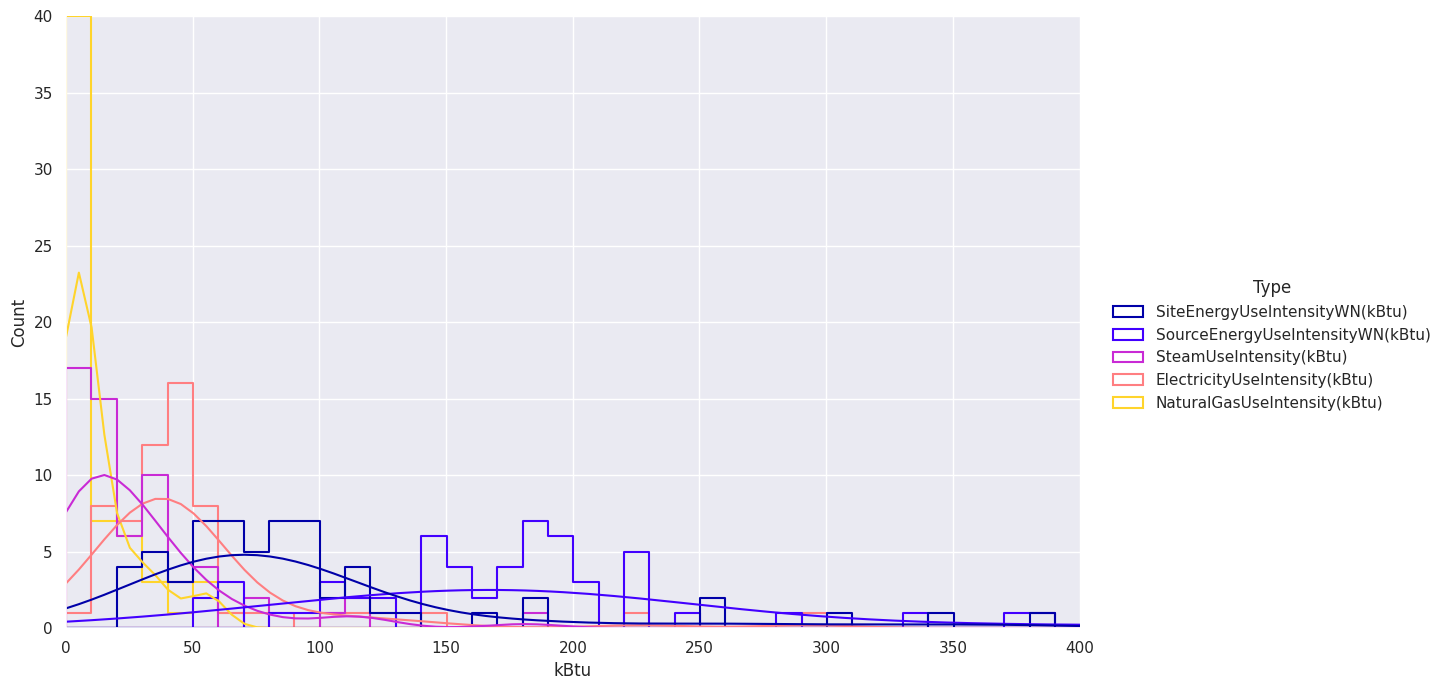

In [56]:
kbtu_intens_feats = [
    "SiteEnergyUseIntensityWN(kBtu)",
    "SourceEnergyUseIntensityWN(kBtu)",
    "SteamUseIntensity(kBtu)",
    "ElectricityUseIntensity(kBtu)",
    "NaturalGasUseIntensity(kBtu)",
]
intens_kbtu_df = pd.DataFrame(columns=["kBtu", "Type"])

for kbtu_intens in kbtu_intens_feats:
    val_list = build_ener_df_w_intens[kbtu_intens].to_list()
    intens_kbtu_df = pd.concat(
        [
            intens_kbtu_df,
            pd.DataFrame({"kBtu": val_list, "Type": [kbtu_intens] * len(val_list)}),
        ]
    )

intens_kbtu_df = intens_kbtu_df.drop(intens_kbtu_df[intens_kbtu_df.kBtu == 0].index)

intens_kbtu_df.reset_index(drop=True, inplace=True)
sns.displot(
    intens_kbtu_df,
    x="kBtu",
    hue="Type",
    height=7,
    aspect=1.6,
    bins=100,
    element="step",
    lw=1.5,
    kde=True,
    alpha=0.0,
    palette="gnuplot2",
)
plt.xlim(0, 400)
plt.ylim(0, 40)
plt.show()


## Visualisation de la répartition des intensités énergétiques par type de bien <a class="anchor" id="vis_repar_intens_typ_prop"></a>

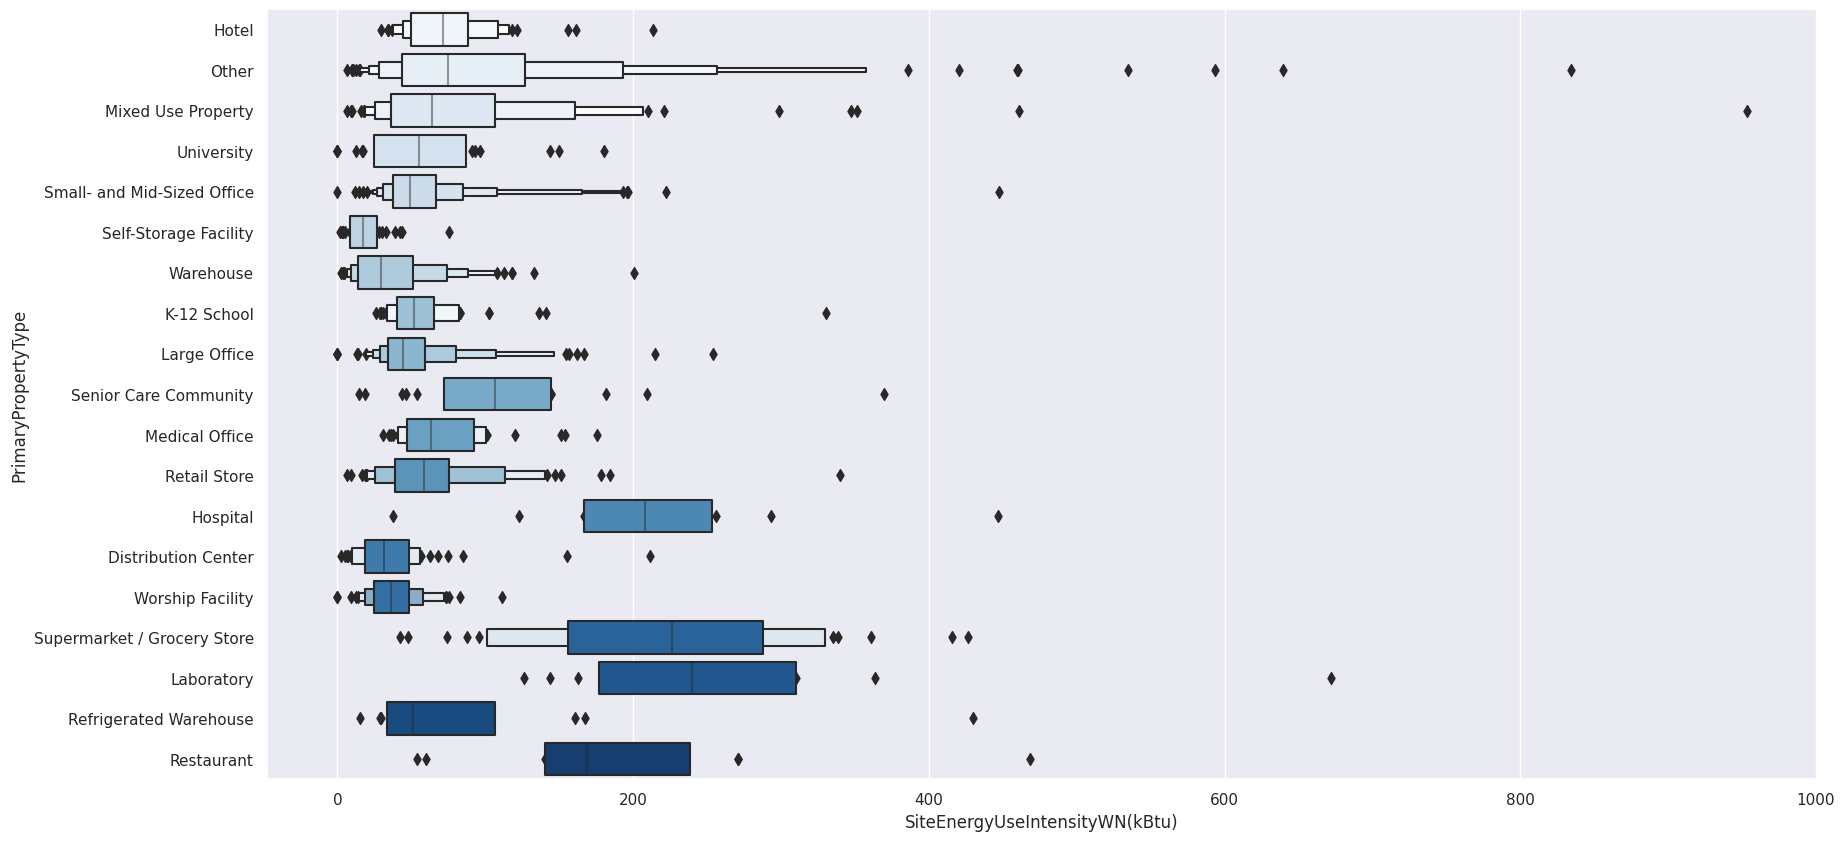

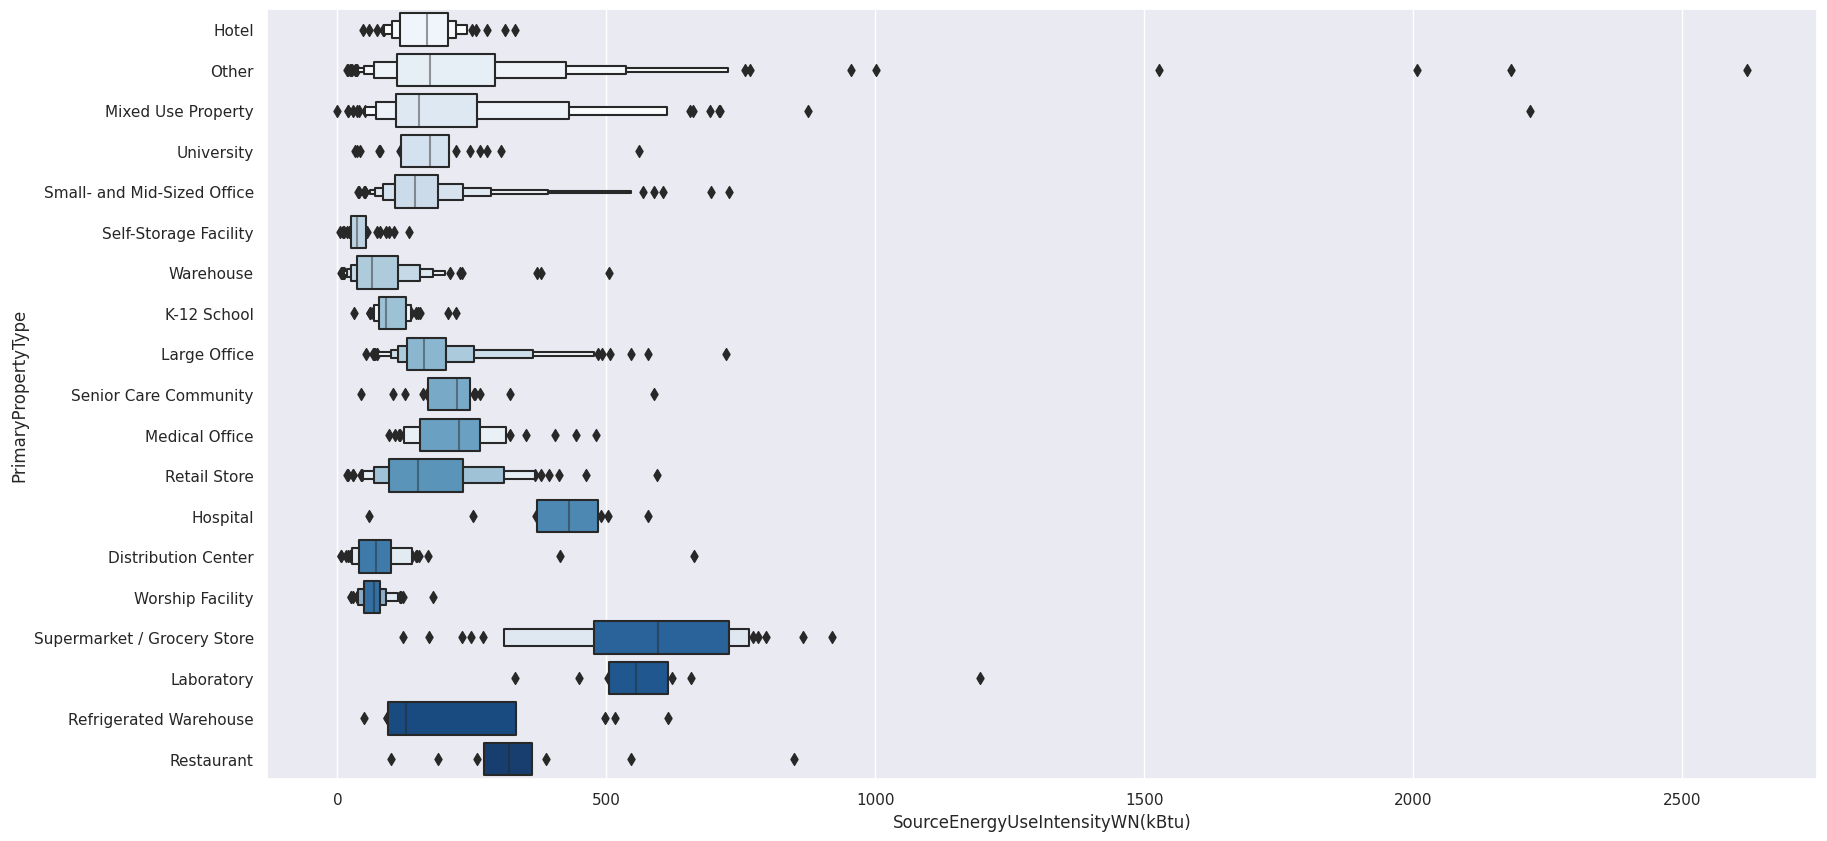

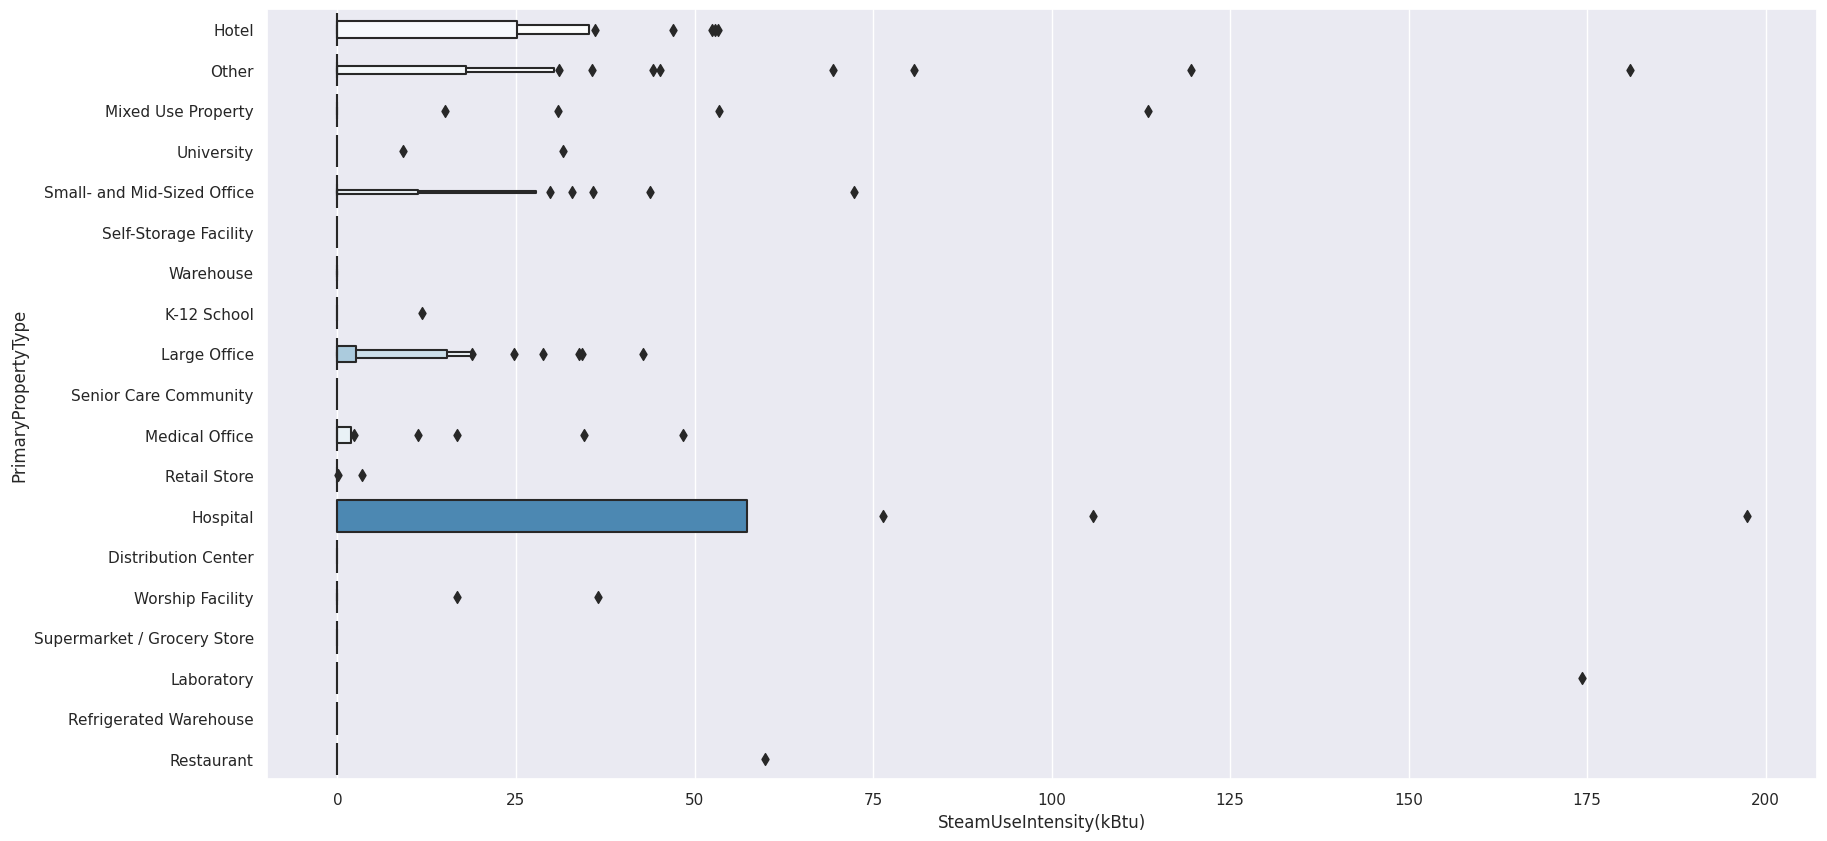

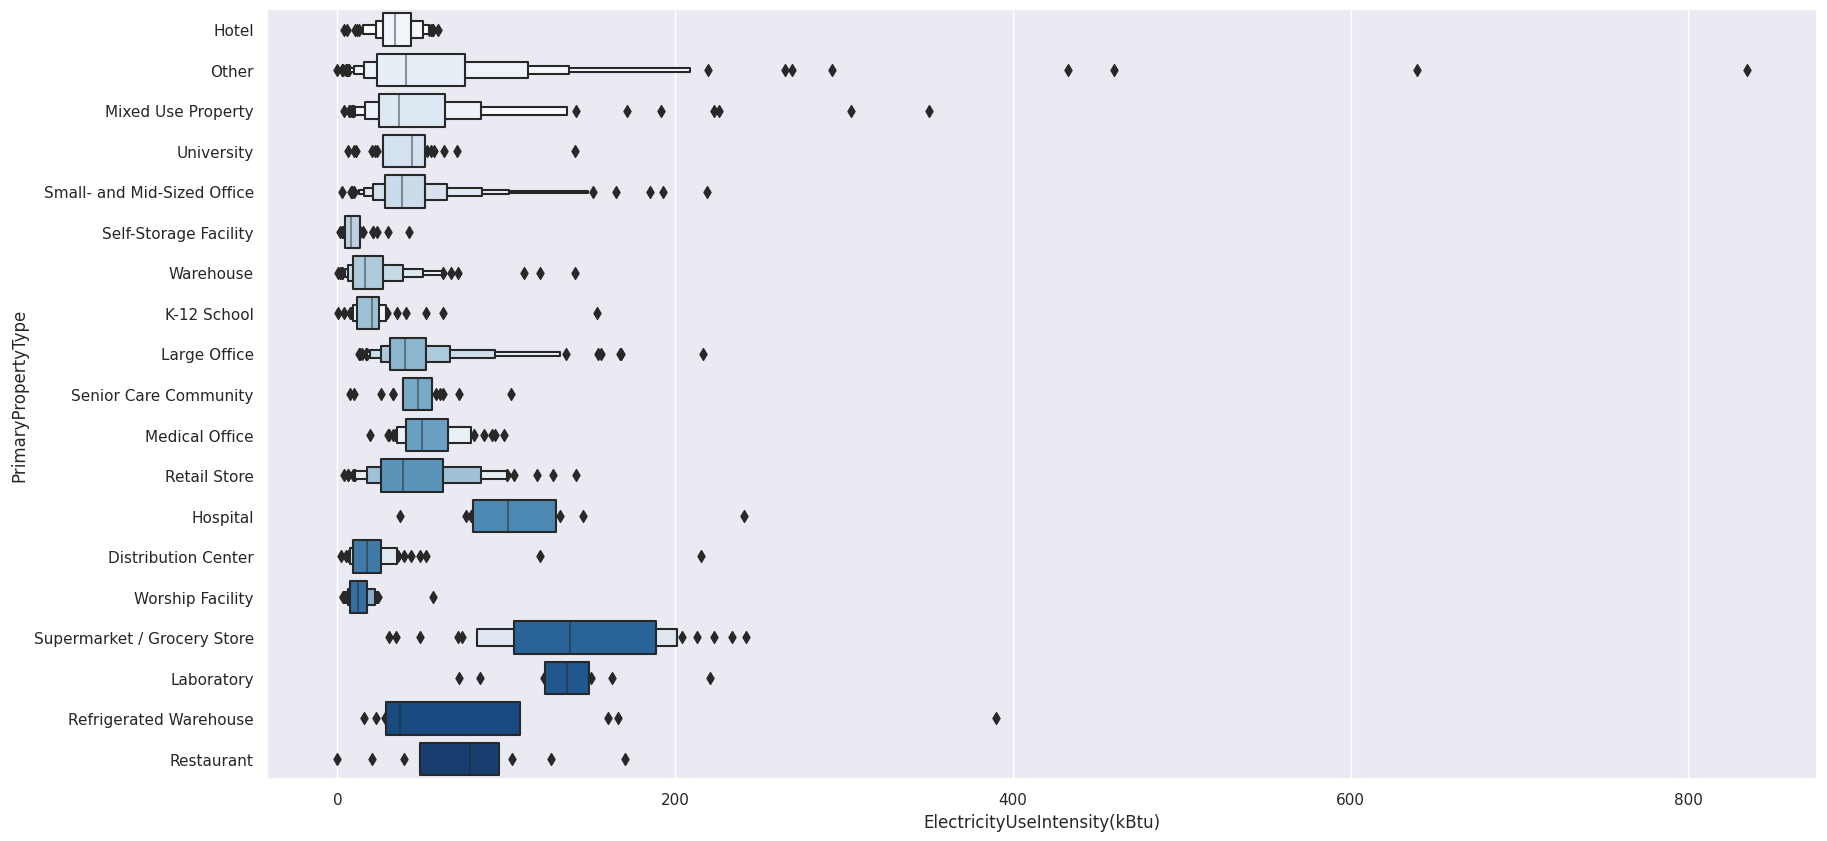

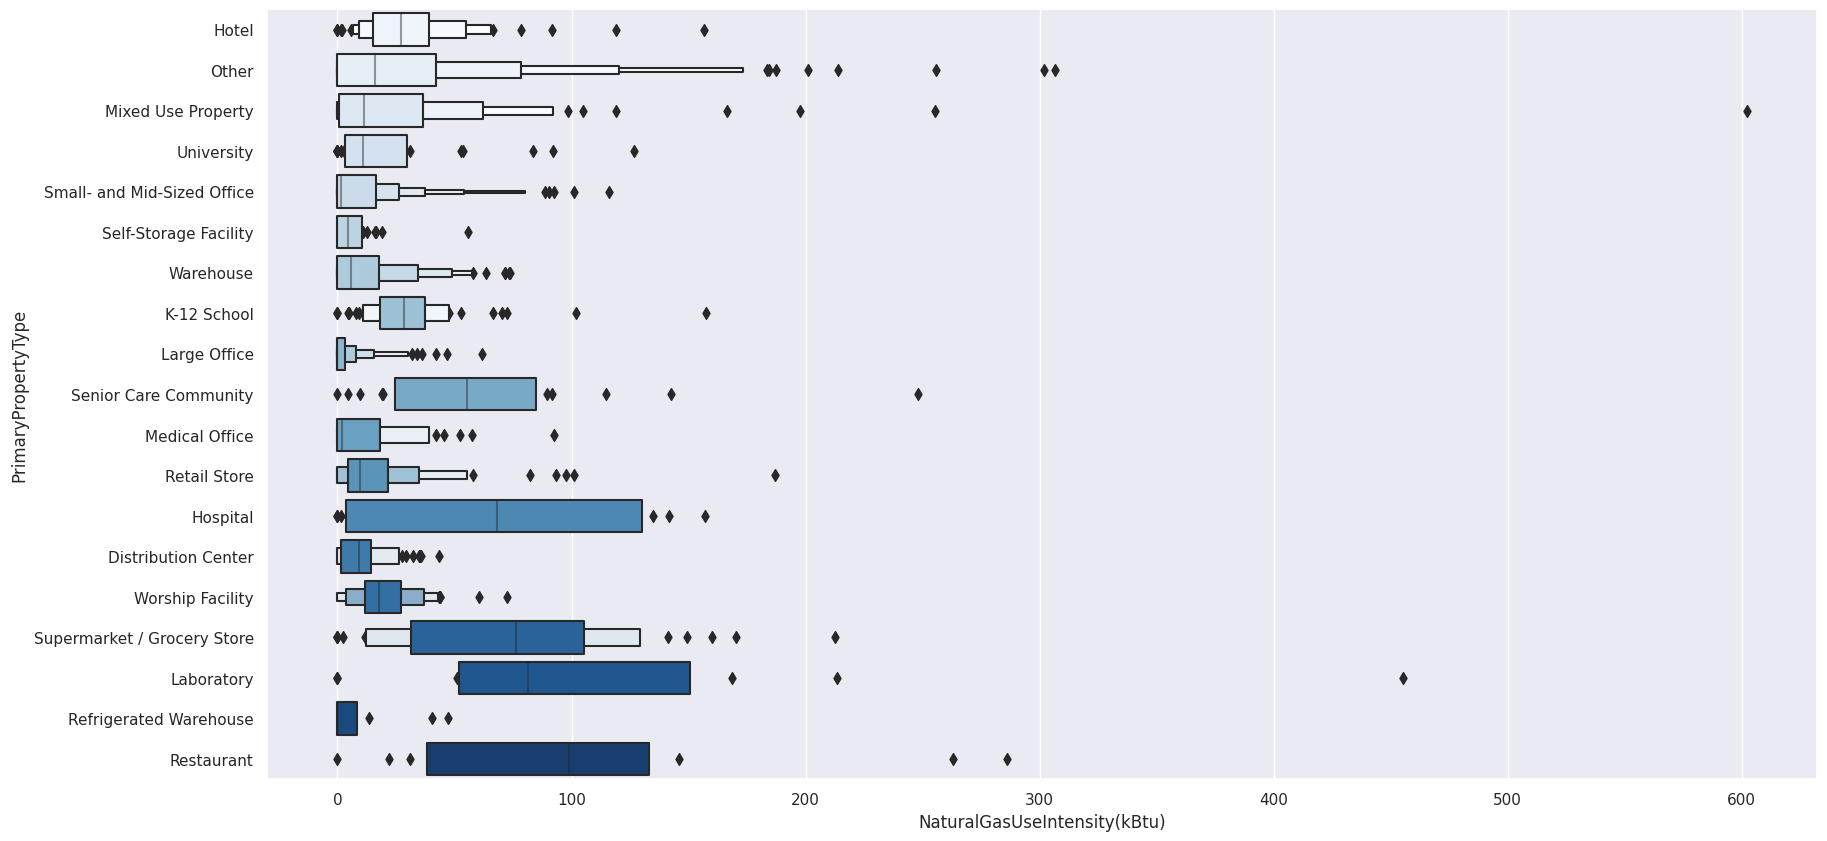

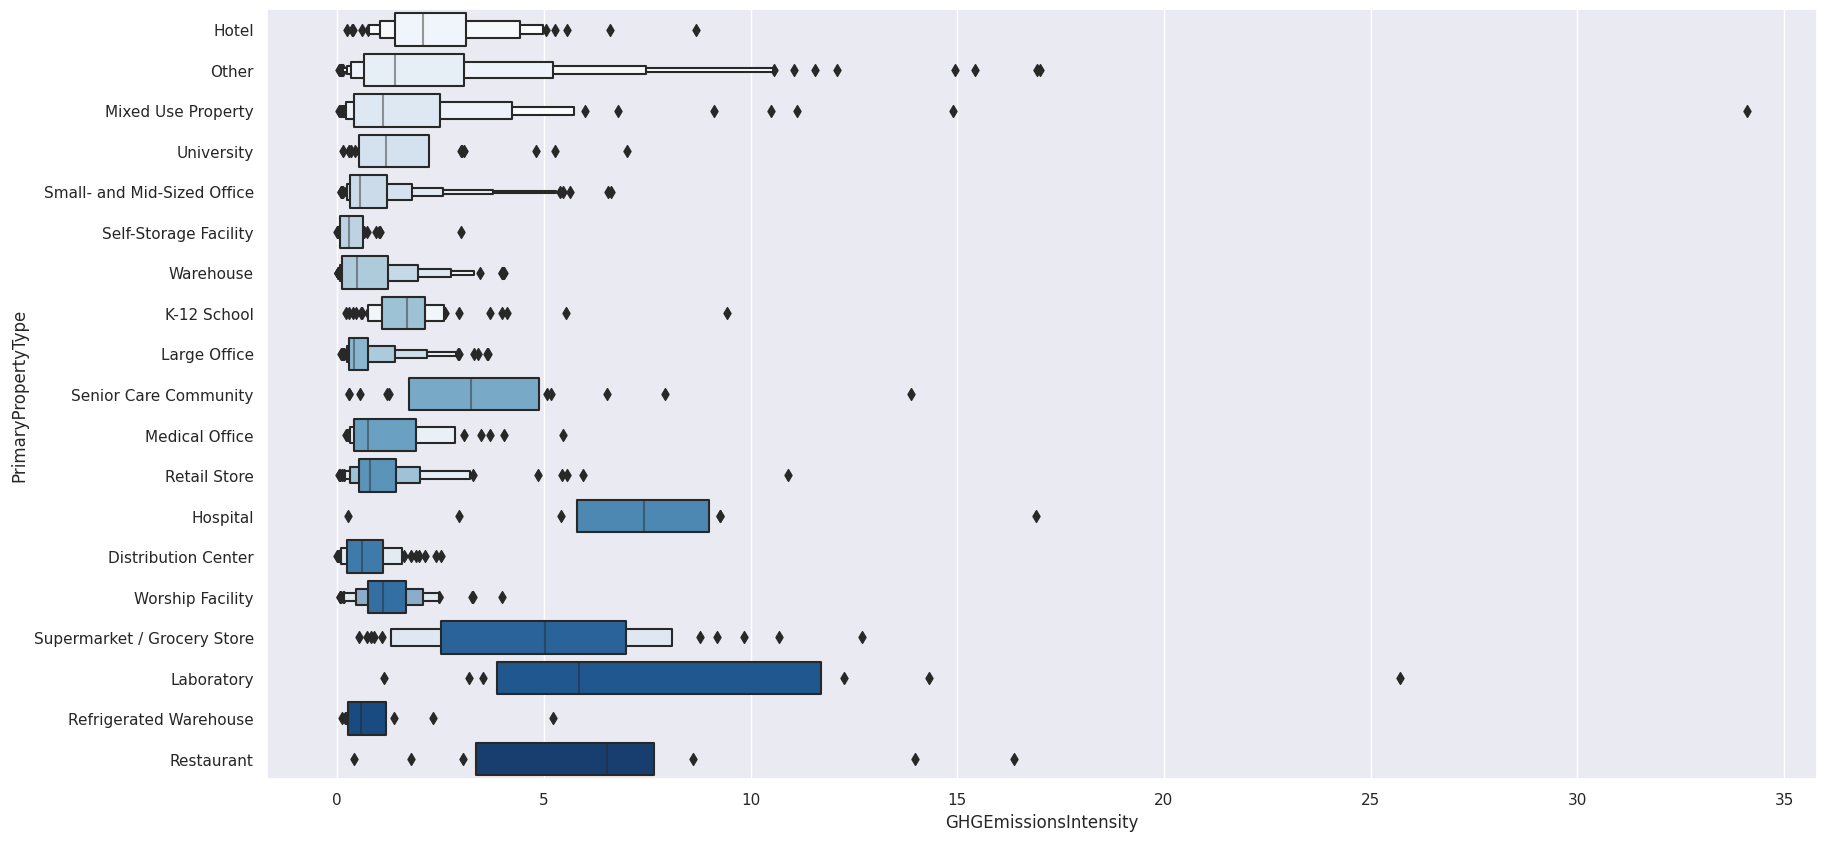

In [57]:
ener_feature_list = [
    "SiteEnergyUseIntensityWN(kBtu)",
    "SourceEnergyUseIntensityWN(kBtu)",
    "SteamUseIntensity(kBtu)",
    "ElectricityUseIntensity(kBtu)",
    "NaturalGasUseIntensity(kBtu)",
    "GHGEmissionsIntensity",
]

for ener_feat in ener_feature_list:
    sns.boxenplot(
        y=build_ener_df_w_intens["PrimaryPropertyType"],
        x=build_ener_df_w_intens[ener_feat],
        palette="Blues",
    )
    sns.set(rc={"figure.figsize": (20, 10)})
    plt.show()


## Évaluation de la relation entre la consommation d'énergie et les émissions et la cote ENERGY STAR <a class="anchor" id="relat_es_ener_emis"></a>
### Visualisation de la corrélation entre ENERGY STAR et les intensités de consommation d'énergie par type de propriété <a class="anchor" id="vis_corr_es_inten"></a>

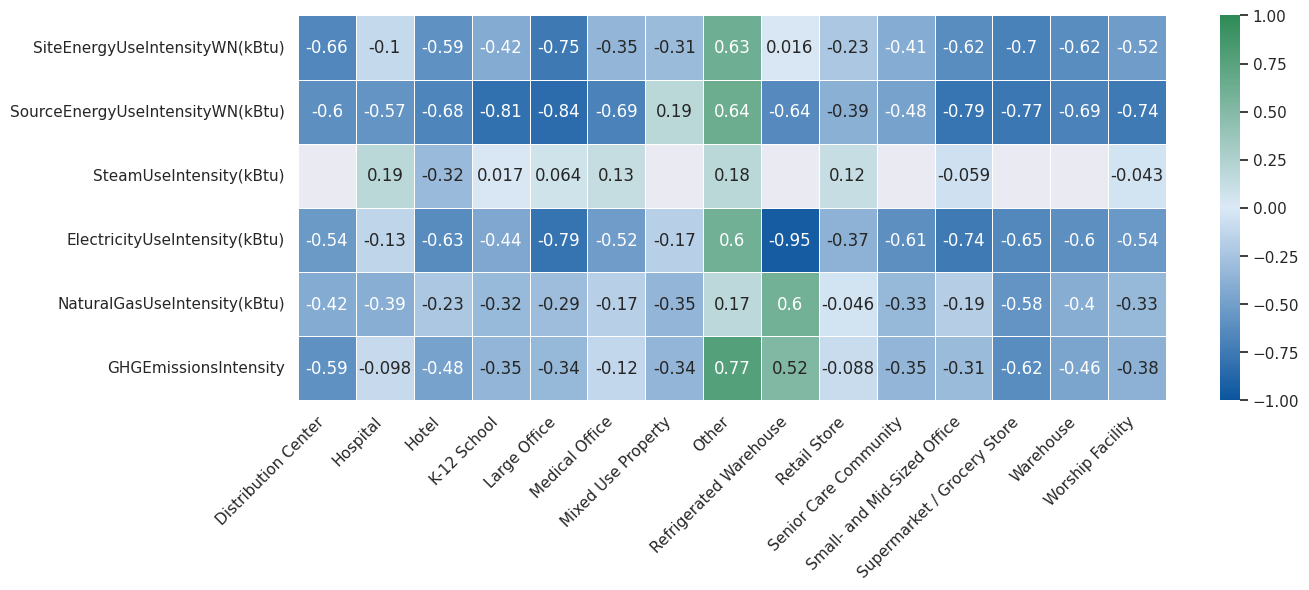

In [58]:
build_ener_df_w_intens_enstr = build_ener_df_w_intens.loc[
    ~build_ener_df_w_intens["ENERGYSTARScore"].isna()
]
prop_types = sorted(set(build_ener_df_w_intens_enstr["PrimaryPropertyType"].to_list()))
build_type_corr_df = pd.DataFrame(
    index=ener_feature_list, columns=prop_types, dtype="float64"
)

for prop_type in prop_types:
    prop_type_df = build_ener_df_w_intens_enstr.loc[
        build_ener_df_w_intens_enstr["PrimaryPropertyType"] == prop_type
    ]

    for index, row in build_type_corr_df.iterrows():
        build_type_corr_df.at[index, prop_type] = (
            prop_type_df[[index, "ENERGYSTARScore"]].corr().to_numpy()[0][1]
        )

f, ax = plt.subplots(figsize=(14, 5))
cmap = lsc.from_list("DbLbDb", [theme_clrs[5], theme_clrs[0], "seagreen"])

sns.heatmap(
    build_type_corr_df,
    vmin=-1.0,
    vmax=1.0,
    cmap=cmap,
    annot=True,
    linewidths=0.5,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.show()


### Graphiques de régression ENERGY STAR et intensité des émissions par type de propriété <a class="anchor" id="regres_es_emis"></a>

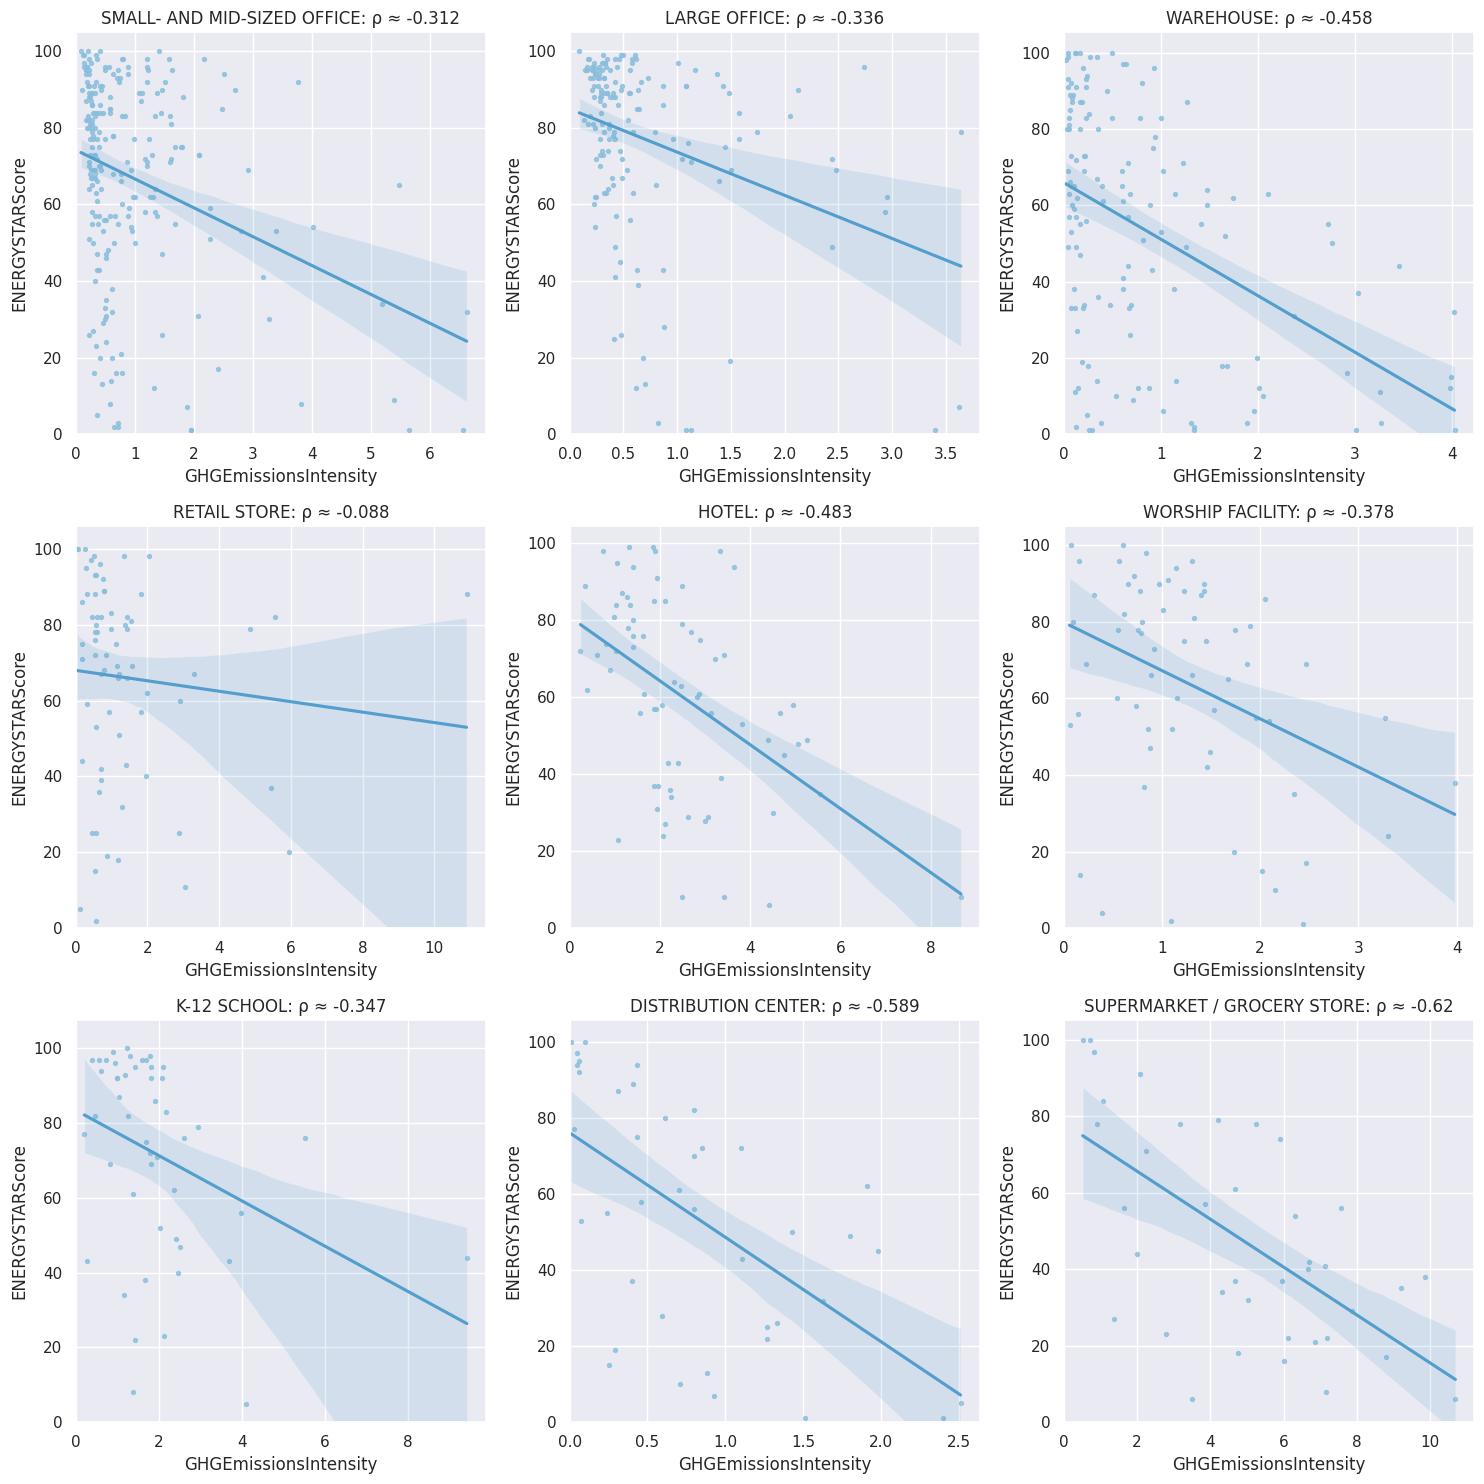

In [59]:
ghg = "GHGEmissionsIntensity"
build_ener_df_w_enstr = build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()]
top_prop_types = [
    x
    for x in build_ener_df_w_enstr["PrimaryPropertyType"]
    .value_counts()
    .index.values.tolist()
    if x not in ["Other", "Mixed Use Property"]
][0:9]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))
sp_locs = [i for i in ax1] + [i for i in ax2] + [i for i in ax3]
loop_num = 0

for prop_type in top_prop_types:
    build_ener_prop_type_df = build_ener_df_w_enstr.loc[
        build_ener_df_w_enstr["PrimaryPropertyType"] == prop_type
    ]
    corr_coeff = (
        build_ener_prop_type_df[["GHGEmissionsIntensity", "ENERGYSTARScore"]]
        .corr()
        .to_numpy()[0][1]
    )
    rp = sns.regplot(
        data=build_ener_prop_type_df,
        x="GHGEmissionsIntensity",
        y="ENERGYSTARScore",
        ax=sp_locs[loop_num],
        line_kws={"color": theme_clrs[3]},
        scatter_kws={"color": theme_clrs[2], "s": 8},
    )

    rp.set(xlim=(0, None))
    rp.set(ylim=(0, None))
    sp_locs[loop_num].set_title(
        f"{prop_type.upper()}: \u03C1 \u2248 {round(corr_coeff, 3)}"
    )
    loop_num += 1

plt.tight_layout()
plt.show()


### MANOVA entre ENERGY STAR et les intensités de consommation d'énergie <a class="anchor" id="manova"></a>
* Cela a été fait afin d'évaluer la corrélation entre l'ensemble des intensités de consommation d'énergie et d'émissions et le score ENERGY STAR.
* Cela montre que le score ENERGY STAR est fortement dépendant de l'ensemble des valeurs d'intensité dans tous les cas sauf dans celui des hôpitaux.

In [60]:
intensities = [
    "SiteEnergyUseIntensityWN",
    "SourceEnergyUseIntensityWN",
    "SteamUseIntensity",
    "ElectricityUseIntensity",
    "NaturalGasUseIntensity",
    "GHGEmissionsIntensity",
]
for prop_type in ["All Property Types"] + prop_types:
    if prop_type == "Other":
        continue

    if not prop_type == "All Property Types":
        prop_type_df = build_ener_df_w_intens_enstr.loc[
            build_ener_df_w_intens_enstr["PrimaryPropertyType"] == prop_type
        ].copy()
    else:
        prop_type_df = build_ener_df_w_intens_enstr.copy()

    if (
        prop_type_df.shape[0] == 0
        or len(set(prop_type_df["ENERGYSTARScore"].to_list())) == 1
    ):
        continue

    prop_type_df.columns = prop_type_df.columns.str.replace("\(kBtu\)", "", regex=True)

    depend_vars = []

    for intens in intensities:
        # Avoids singular matrix
        if len(set(prop_type_df[intens].to_list())) > 3:
            depend_vars += [intens]

    manova_mdl = MANOVA.from_formula(
        " + ".join(depend_vars) + " ~ ENERGYSTARScore", data=prop_type_df
    )

    print(f"{prop_type}:\n{manova_mdl.mv_test()}")


All Property Types:
                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6460 6.0000 962.0000 87.8484 0.0000
         Pillai's trace 0.3540 6.0000 962.0000 87.8484 0.0000
 Hotelling-Lawley trace 0.5479 6.0000 962.0000 87.8484 0.0000
    Roy's greatest root 0.5479 6.0000 962.0000 87.8484 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
    ENERGYSTARScore     Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.8872 6.0000 962.0000 20.3895 0.0000
         Pillai's trace 0.1128 6.0000 962.0000 20.3895 0.0000
 Hotel

### ACP du score ENERGY STAR et les valeurs d'intensité <a class="anchor" id="acp"></a>
* Cela montre que :
    * Les valeurs d'intensité et les cotes ENERGY STAR ne sont étroitement liées que si le type de propriété est pris en compte.
    * En raison d'un nombre non négligeable de valeurs aberrantes, les valeurs d'intensité seules ne sont pas un prédicteur précis du score ENERGY STAR.

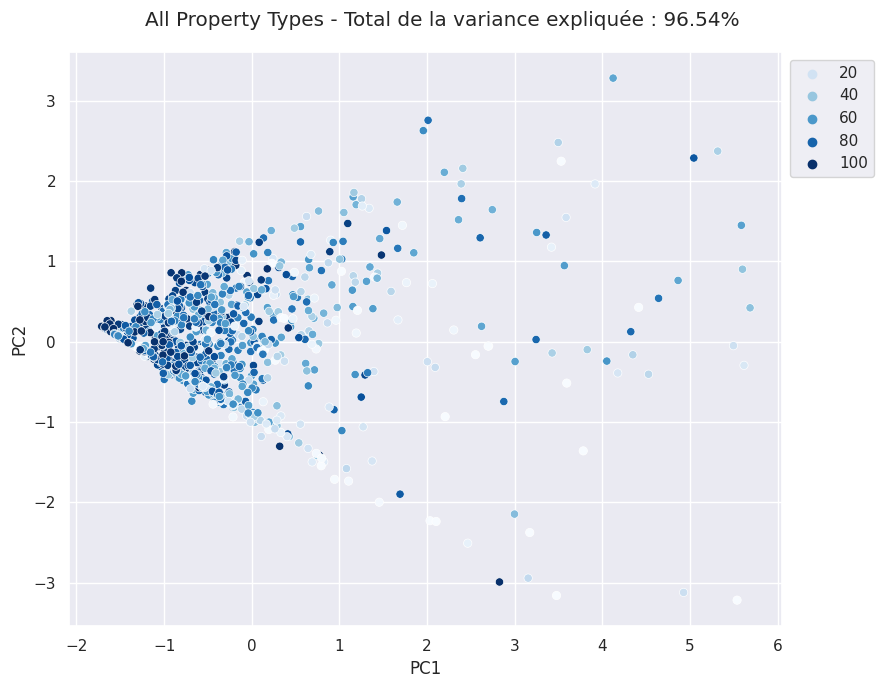

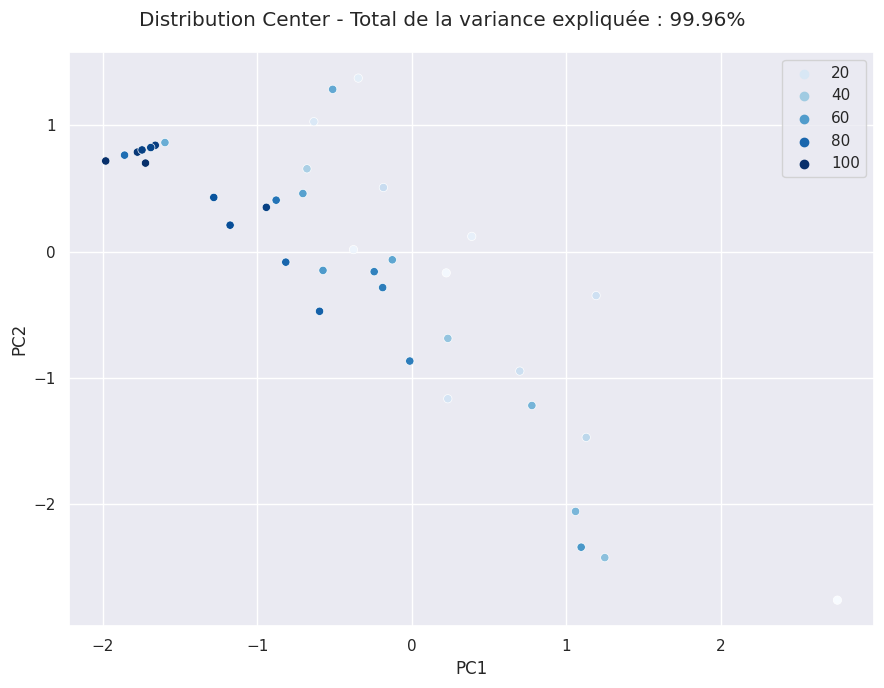

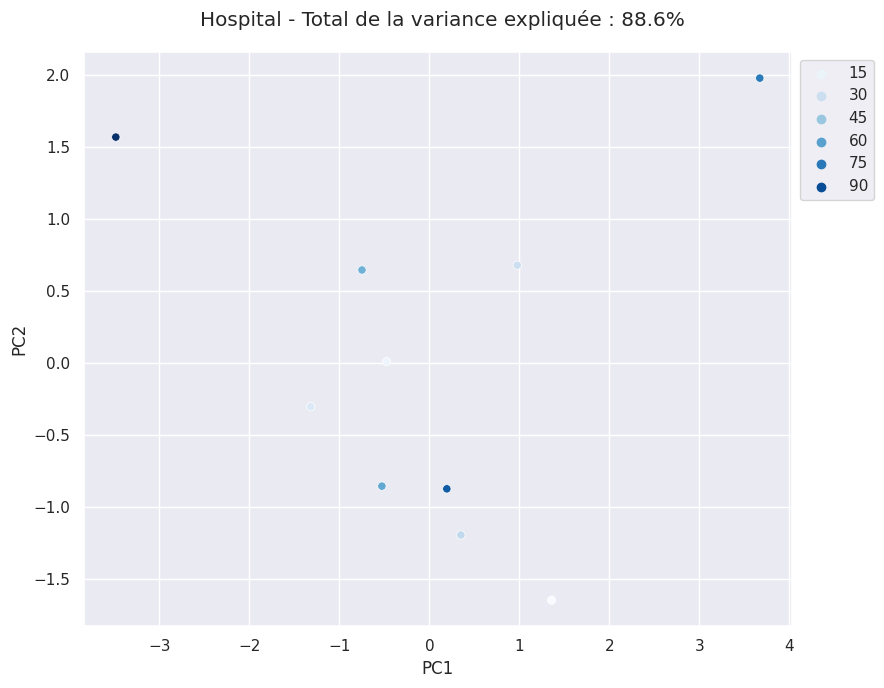

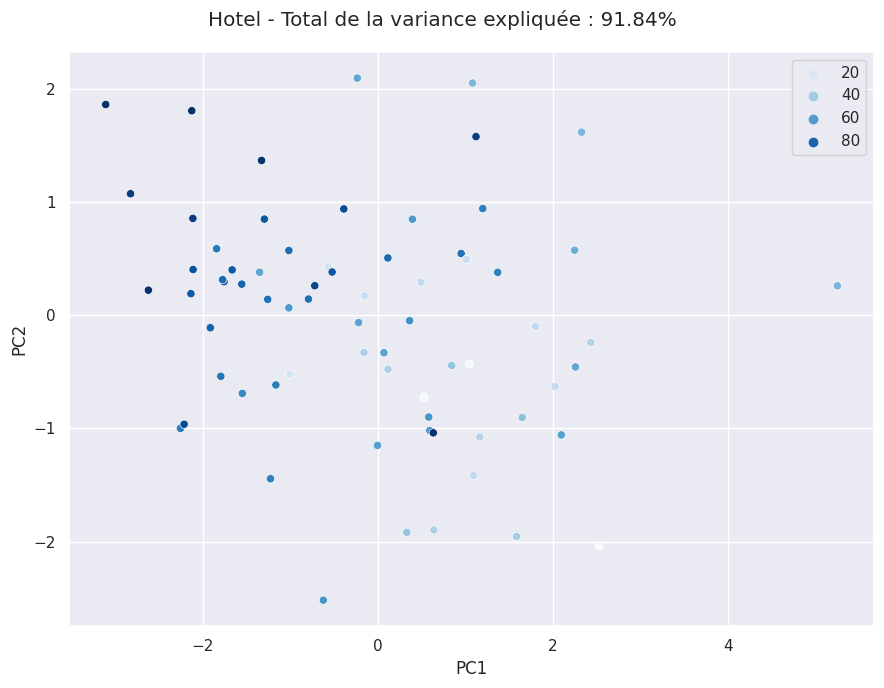

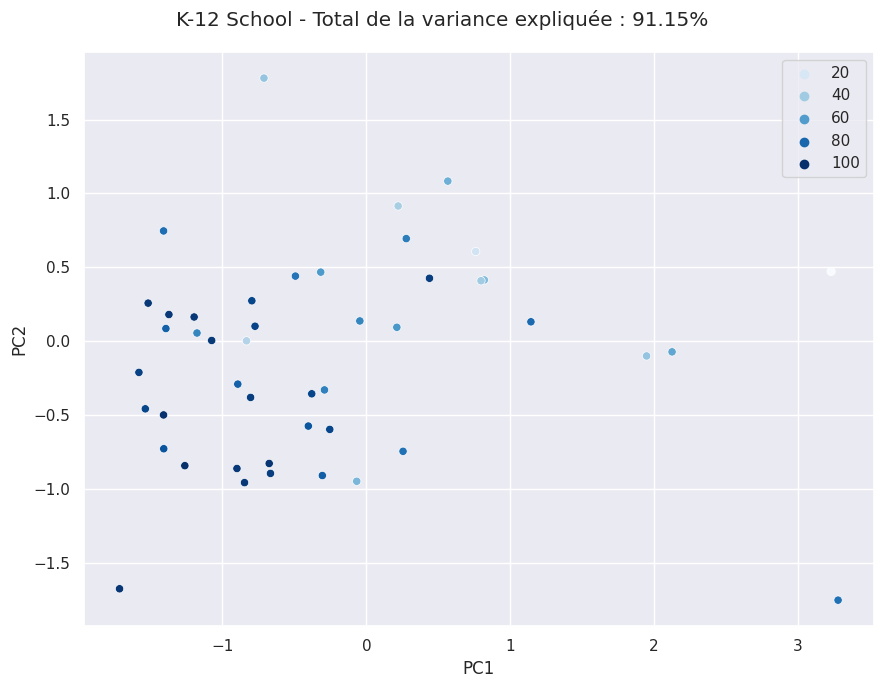

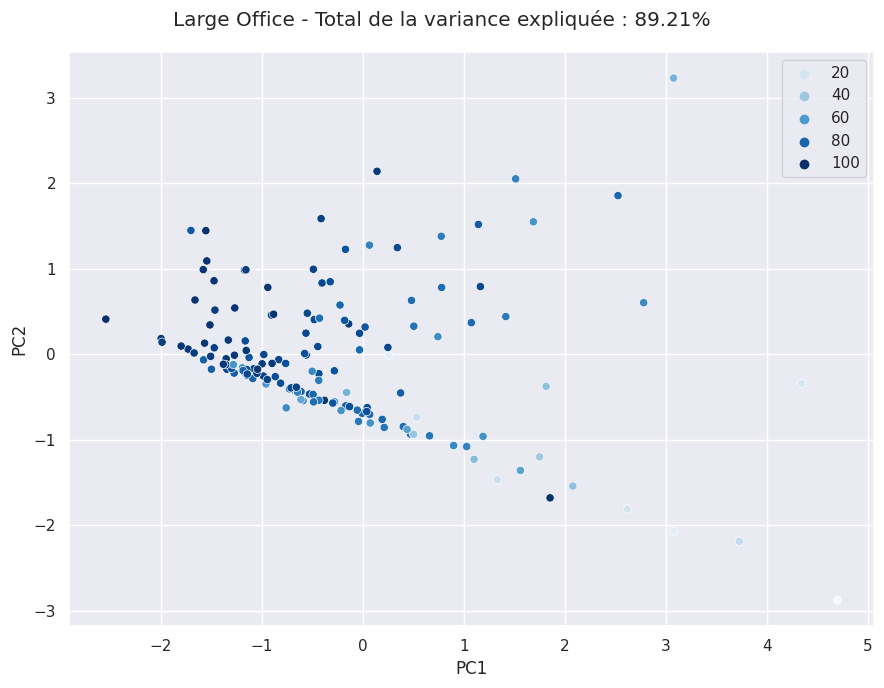

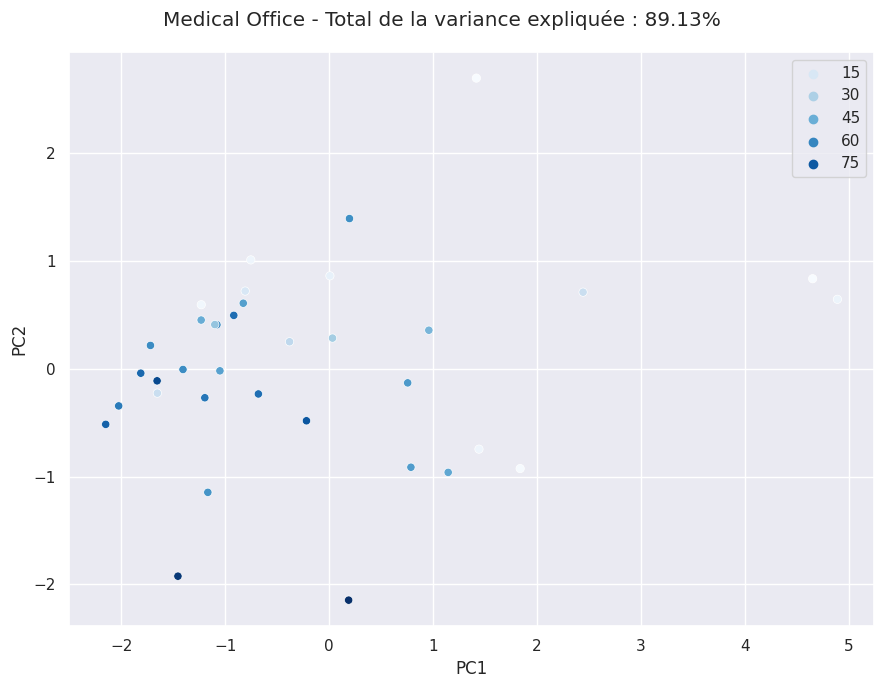

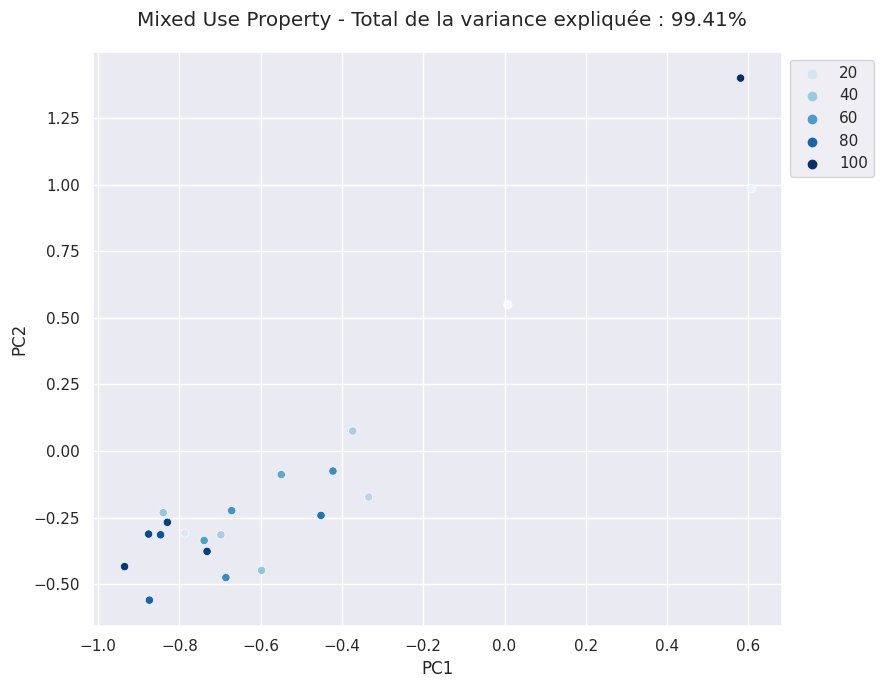

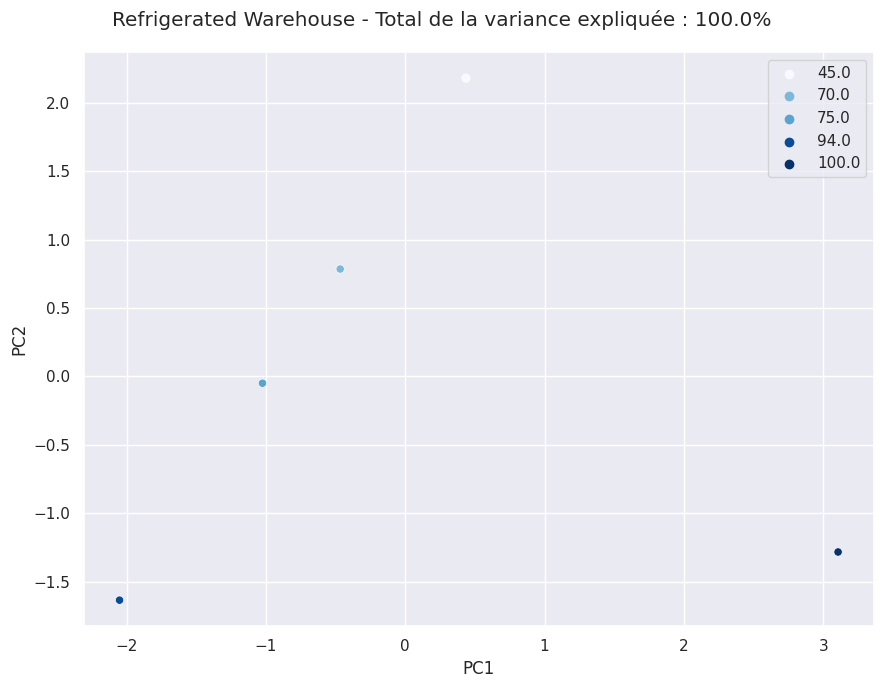

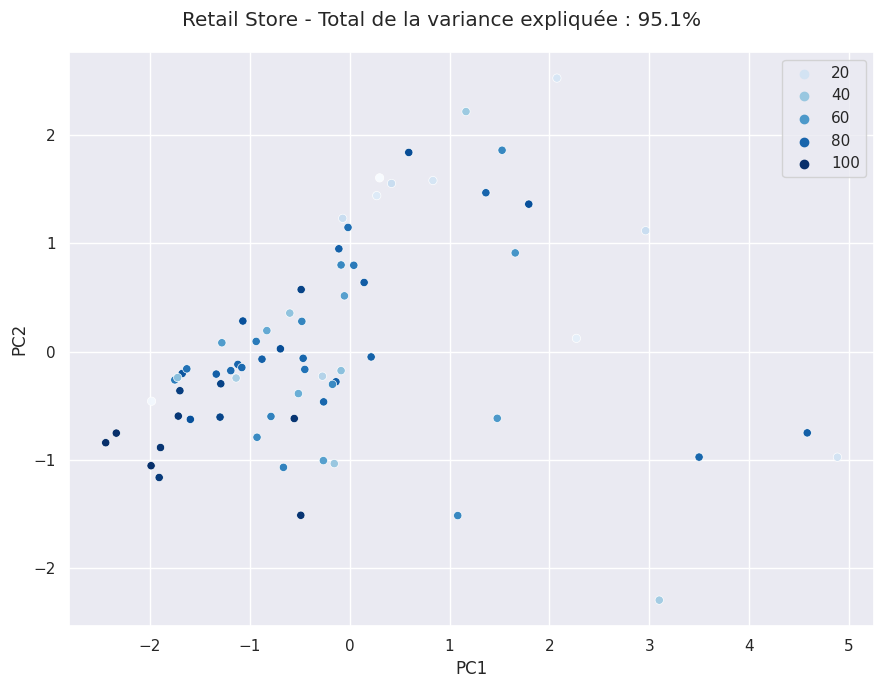

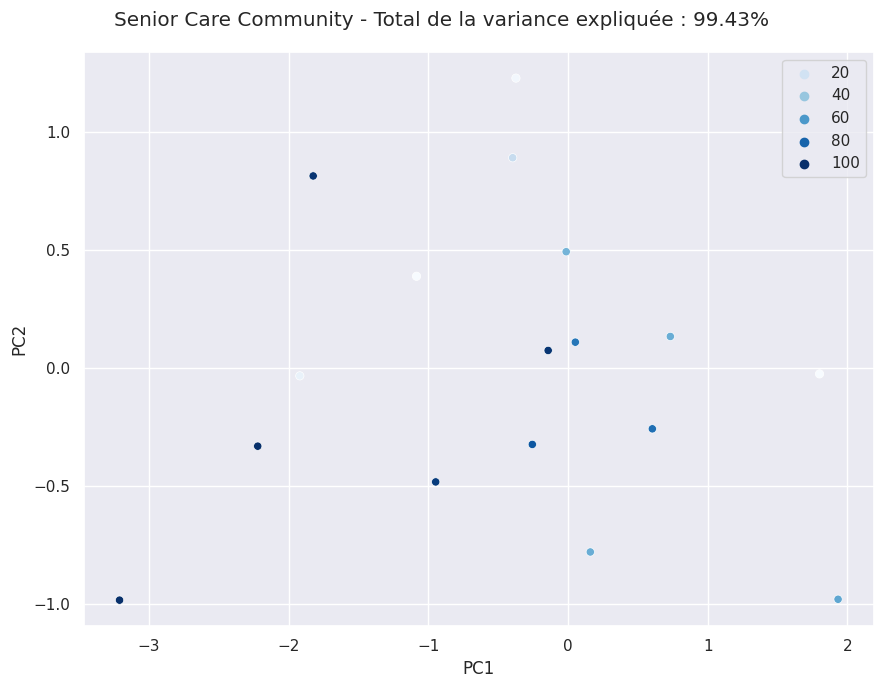

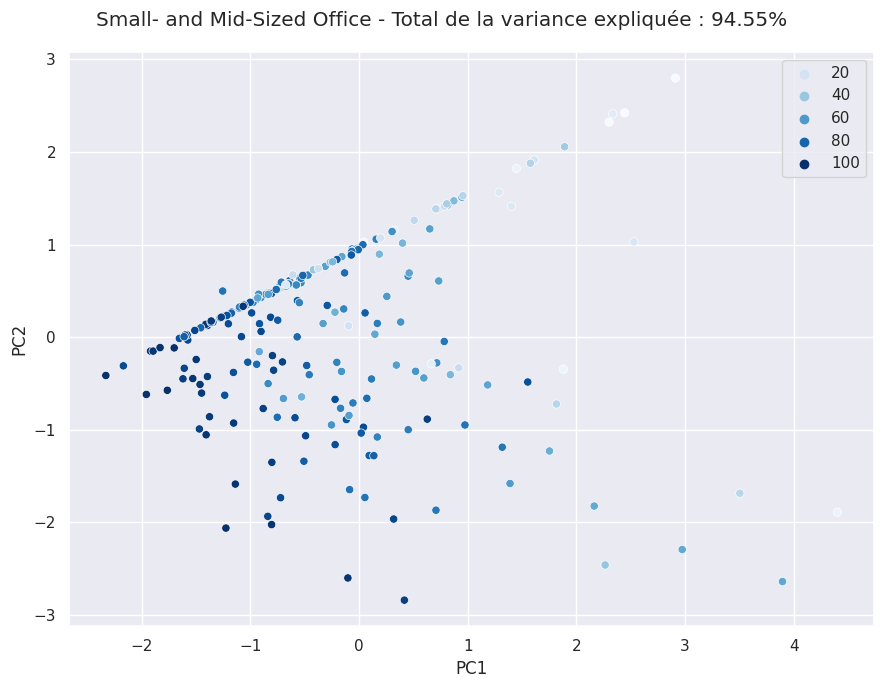

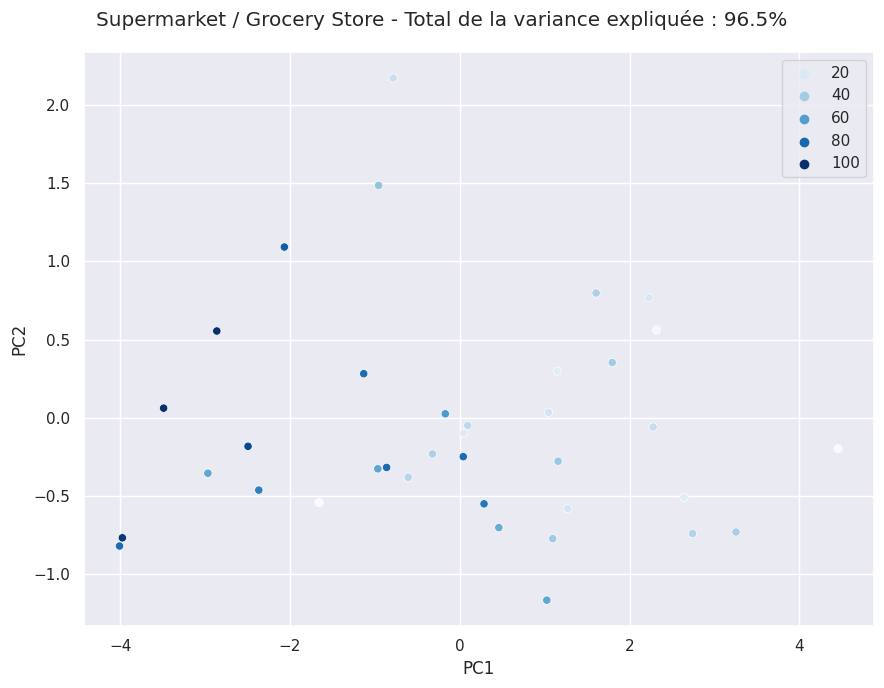

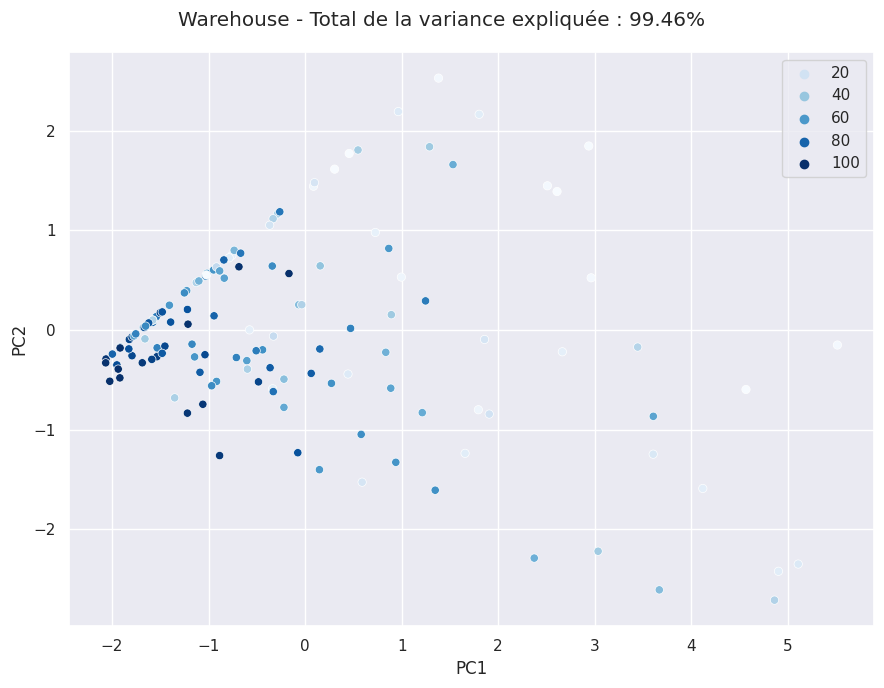

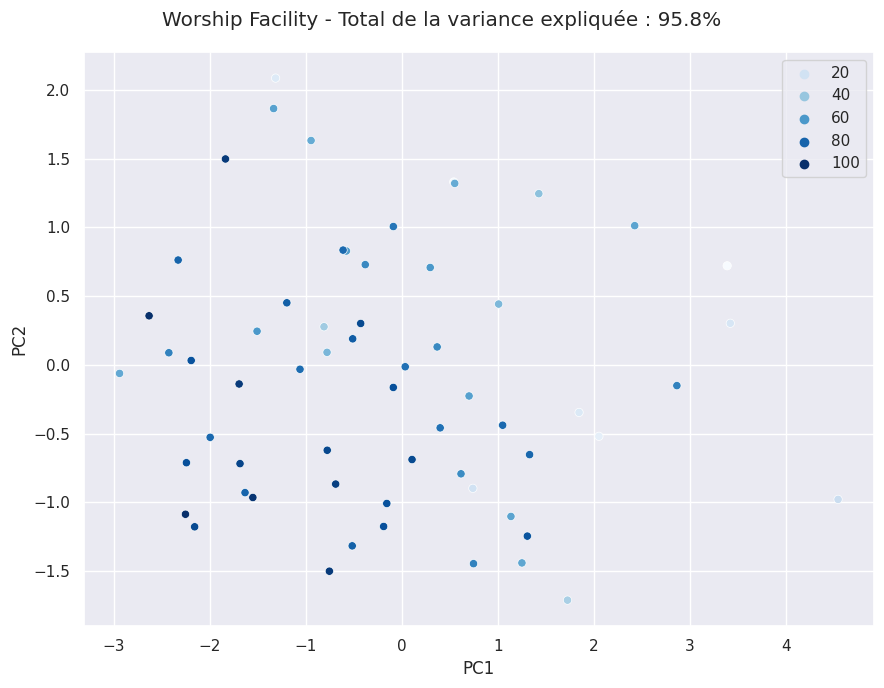

In [61]:
pca = PCA(n_components=2)
feature_list = [
    "SiteEnergyUseIntensityWN(kBtu)",
    "SourceEnergyUseIntensityWN(kBtu)",
    # "SteamUseIntensity(kBtu)",
    "ElectricityUseIntensity(kBtu)",
    "NaturalGasUseIntensity(kBtu)",
    "GHGEmissionsIntensity",
]

for prop_type in ["All Property Types"] + prop_types:
    if prop_type == "Other":
        continue

    if not prop_type == "All Property Types":
        prop_type_df = build_ener_df_w_intens_enstr.loc[
            build_ener_df_w_intens_enstr["PrimaryPropertyType"] == prop_type
        ]
    else:
        prop_type_df = build_ener_df_w_intens_enstr

    if prop_type_df.shape[0] == 0:
        continue

    principal_components = pca.fit_transform(
        StandardScaler().fit_transform(prop_type_df.loc[:, feature_list].values)
    )
    exp_var_pct = round(sum(pca.explained_variance_ratio_) * 100, 2)
    pc_df = pd.concat(
        [
            pd.DataFrame(data=principal_components, columns=["PC1", "PC2"]),
            pd.DataFrame(
                data=prop_type_df["ENERGYSTARScore"].to_list(),
                columns=["ENERGYSTARScore"],
            ),
        ],
        axis=1,
    )
    zcore_to_filter = 3
    z_scores = stats.zscore(pc_df[["PC1", "PC2"]])
    abs_z_scores = np.abs(z_scores)
    filt_entries = (abs_z_scores < zcore_to_filter).all(axis=1)
    pc_df = pc_df[filt_entries]

    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 7))

    fig.suptitle(f"{prop_type} - Total de la variance expliquée : {exp_var_pct}%")

    sp1 = sns.scatterplot(
        data=pc_df,
        x="PC1",
        y="PC2",
        ax=ax,
        hue="ENERGYSTARScore",
        palette="Blues",
    )
    
    sp1.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


## Suppression de caractéristiques non pertinentes <a class="anchor" id="supp_carac_non_pert"></a>
* Les types de caractéristiques suivants sont supprimés :
    * Celles relatives à l'identification de la propriété, le numéro d'identification de l'immeuble étant suffisant.
    * L'adresse, car les coordonnées géographiques sont plus facilement comparables.
    * La liste des types d'utilisation de la propriété, car elle n'est pas ordonnée et les trois premiers types d'utilisation de la propriété sont également fournis.
    * Le nombre d'années pendant lesquelles la propriété a été certifiée ENERGY STAR, ce qui n'est pas pertinent.
    * Toutes les intensités de consommation d'énergie, car elles sont un composite de la superficie de la propriété et de la consommation d'énergie.
    * Valeurs de consommation d'énergie non exprimées en kBtus.
    * Caractéristiques à valeurs invariantes.
    * Caractéristiques avec toutes les valeurs nulles.


In [62]:
build_ener_df = build_ener_df.drop(
    [
        "PropertyName",
        "Address",
        "TaxParcelIdentificationNumber",
        "ListOfAllPropertyUseTypes",
        "YearsENERGYSTARCertified",
        "SiteEUI(kBtu/sf)",
        "SiteEUIWN(kBtu/sf)",
        "SourceEUI(kBtu/sf)",
        "SourceEUIWN(kBtu/sf)",
        "SiteEnergyUse(kBtu)",
        "SiteEnergyUseIntensityWN(kBtu)",
        "SourceEnergyUseIntensityWN(kBtu)",
        "SteamUseIntensity(kBtu)",
        "Electricity(kWh)",
        "ElectricityUseIntensity(kBtu)",
        "NaturalGas(therms)",
        "NaturalGasUseIntensity(kBtu)",
        "GHGEmissionsIntensity",
    ],
    axis=1,
)

for col in build_ener_df.columns:
    if (
        len(set(build_ener_df[col].to_list())) == 1
        or len(build_ener_df[col].loc[~build_ener_df[col].isna()].to_list()) == 0
    ):
        build_ener_df = build_ener_df.drop(labels=col, axis=1)


## Correction des types de données des caractéristiques <a class="anchor" id="corr_type_donn"></a>
* Les caractéristiques catégorielles sont converties en chaînes.
* Les nombres à virgule flottante qui sont toujours des nombres entiers sont convertis en entiers.

In [63]:
build_ener_df = build_ener_df.astype(
    {
        "BuildingType": "string",
        "PrimaryPropertyType": "string",
        "ZipCode": "string",
        "CouncilDistrictCode": "string",
        "Neighborhood": "string",
        "LargestPropertyUseType": "string",
        "SecondLargestPropertyUseType": "string",
        "ThirdLargestPropertyUseType": "string",
        "NumberofBuildings": "int",
        "ENERGYSTARScore": "Int64",
    }
)

build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503 entries, 0 to 1507
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

## Enregistrement du dataframe nettoyé <a class="anchor" id="enreg_df"></a>

In [64]:
build_ener_df.reset_index(drop=True, inplace=True)
build_ener_df.to_feather("build_ener_df.ftr")
